# 🛒 Dự Báo Doanh Thu Cửa Hàng Rossmann

**Rossmann** là một trong những chuỗi bán lẻ dược mỹ phẩm lớn nhất tại châu Âu, sở hữu hơn 3.000 cửa hàng tại nhiều quốc gia. Với quy mô lớn và hoạt động liên tục, việc dự báo doanh thu hằng ngày của từng cửa hàng là vô cùng quan trọng nhằm tối ưu hóa nguồn lực, quản lý tồn kho, lập kế hoạch nhân sự và cải thiện hiệu quả kinh doanh.

Trong dự án này, nhóm sử dụng **Rossmann Store Sales** – một bộ dữ liệu nổi tiếng được công bố trên nền tảng Kaggle. Dataset cập nhật đến tháng 7 năm 2015 bao gồm thông tin lịch sử doanh thu theo ngày của 1.115 cửa hàng, cùng với các đặc trưng liên quan như loại cửa hàng, chương trình khuyến mãi, thông tin đối thủ cạnh tranh, ngày nghỉ lễ, và một số biến mô tả đặc điểm hoạt động của từng store.

### 🎯 Mục tiêu bài toán
Xây dựng mô hình **Machine Learning** dự báo doanh thu (**Sales**) cho mỗi cửa hàng trong tương lai, từ đó hỗ trợ Rossmann đưa ra các quyết định vận hành chính xác và hiệu quả hơn.

### 🔍 Phạm vi nghiên cứu
* **Hiểu dữ liệu**: Cấu trúc, ý nghĩa các biến.
* **Khám phá đặc trưng (EDA)**: Phân tích đơn biến, đa biến.
* **Phân tích sâu**: Tìm kiếm insight từ dữ liệu.
* **Mô hình hóa**: Xây dựng và so sánh các mô hình
* **Đánh giá**: Sử dụng các chỉ số phù hợp để đo lường hiệu quả.

In [255]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

**Loading Data**
---


In [256]:
# Load the datasets
store = pd.read_csv("data/store.csv")
train = pd.read_csv("data/train.csv")


C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\2479832801.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data/train.csv")


**Data Understanding**
---


> Chúng ta có 2 bộ dữ liệu chính là store.csv và test.csv, hãy cùng đi tìm hiểu dữ liệu trong từng bộ dữ liệu


### Đầu tiên là `store.csv`


In [257]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [258]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


1. Dữ liệu gồm 1115 dòng với 10 cột

2. Các numerical features bao gồm: `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2`, `Promo2SinceWeek`,   `Promo2SinceYear`

3. Các features có kiểu object bao gồm: `StoreType`, `Assortment`, `PromoInterval`

### Kiểm tra missing value


In [259]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

1. Dữ liệu bị missing khá nhiều

2. Các biến liên quan đến đối thủ đều có missing value, tuy nhiên biến CompetitionDistance chỉ có 3 missing value có thể là do các cửa hàng đó thực sự không có cửa hàng đối thủ nào ở gần, còn các biến CompetitionOpenSinceMonth và CompetitionOpenSinceYear có cùng số missing value là 354 lý do có thể là vì không thu thập được thông tin của đối thủ nên để tiện cho phần phân tích sau chúng ta sẽ coi như các cửa hàng này không có đối thủ cạnh tranh hoặc đối thủ cạnh tranh ở quá xa

3. Các biến liên quan đến promo2 đều cùng có rất nhiều missing value là 544 trên tổng số 1115 dòng dữ liệu, trong khi biến promo2 thì không có missing value nào

### Kiểm tra duplicate data


In [260]:
store.duplicated().sum()

0

Không có dữ liệu trùng lặp


### Thống kê cơ bản về store


In [261]:
store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

1. Không có giá trị âm trong bộ dữ liệu trong toàn bộ dữ liệu cho thấy dữ liệu khá logic

2. Biến CompetitionDistance có mean = 5404 gấp hơn 2 lần so với median = 2325, cho thấy dữ liệu bị lệch phải nặng và có biến động khá lớn khi std = 7663 lớn hơn mean

3. Biến Promo2 chỉ nhận giá trị 0 và 1

### Tiếp theo là `train.csv`


In [262]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [263]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


- Dữ liệu khá lớn gồm 1017209 dòng với 9 cột
- Các numerical features bao gồm: `Sales`, `Customers`, `Store`, `DayOfWeek`, `Open`, `Promo`, `SchoolHoliday`
- Các features có kiểu object bao gồm: `Date`, `StateHoliday`

### Kiểm tra missing value


In [264]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Dữ liệu khá sạch, không có missing value nào


### Kiểm tra duplicate data


In [265]:
train.duplicated().sum()

0

Dữ liệu không bị trùng lặp


### Thống kê cơ bản về train


In [266]:
train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

1. Quan sát không thấy xuất hiện giá trị âm trong bộ dữ liệu

2. Trung bình 1 ngày mỗi cửa hàng có doanh thu khoảng 5773 dollars với 633 khách hàng

3. Có nhưng giá trị 0 ở biến `Sales` và `Customers`, điều này là hợp lý vì có thể có những ngày cửa hàng đóng cửa hoặc không có khách hàng nào đến mua sắm

4. Biến `Open` có mean = 0.83 nghĩa là các cửa hàng mở cửa khoảng 83% số ngày trong năm từ đó suy ra có khoảng 17% số ngày cửa hàng đóng cửa (tương ứng với Chủ nhật và các ngày lễ lớn).

5. Biến `Promo` có mean = 0.381. Điều này cho thấy chuỗi cửa hàng chạy các chương trình khuyến mãi ngắn hạn khá thường xuyên, chiếm khoảng 38% tổng số ngày kinh doanh.

6. Các biến `Sales` và `Customers` có độ lệch phải khá lớn khi mean > median, điều này cho thấy có một số ngày doanh số và lượng khách hàng rất cao so với các ngày còn lại, làm tăng giá trị trung bình của chúng.

7. Các biến `Open`, `Promo` và `SchoolHoliday` chỉ nhận giá trị 0 và 1

In [267]:
# Chuyển cột 'Date' sang kiểu datetime
train['Date'] = pd.to_datetime(train['Date'])

In [268]:
# Kiểm tra khoảng thời gian của dữ liệu train
print(f"Ngày bắt đầu: {train['Date'].min()}")
print(f"Ngày kết thúc: {train['Date'].max()}")
print(f"Khoảng thời gian: {(train['Date'].max() - train['Date'].min()).days+1} ngày")

Ngày bắt đầu: 2013-01-01 00:00:00
Ngày kết thúc: 2015-07-31 00:00:00
Khoảng thời gian: 942 ngày


_Dữ liệu kéo dài trong <b>942</b> ngày từ 2013-01-01 đến 2015-07-31 tức là hơn 2 năm rưỡi_


Tiếp theo chúng ta sẽ kiểm tra xem dữ liệu có bị lỗi trùng ngày hay thiếu ngày không

In [269]:
# Xem trong khoảng thời gian từ ngày đầu tiên đến ngày cuối cùng có bị thiếu ngày không
date_range = pd.date_range(start=train['Date'].min(), end=train['Date'].max())
missing_dates = date_range.difference(train['Date'])
print(f"Số ngày bị thiếu: {len(missing_dates)}")

Số ngày bị thiếu: 0


In [270]:
# Kiểm tra xem dữ liệu ngày của các cửa hàng có liên tục và đầy đủ không hay bị lặp lại
store_date_counts = train.groupby('Store')['Date'].nunique()
duplicate_store_dates = store_date_counts[store_date_counts < (train['Date'].max() - train['Date'].min()).days + 1]
print(f"Số cửa hàng có dữ liệu ngày không đầy đủ: {len(duplicate_store_dates)}")

Số cửa hàng có dữ liệu ngày không đầy đủ: 181


In [271]:
# Liệt kê các cửa hàng nào thiếu những ngày nào
dem = 0
for store_id in duplicate_store_dates.index:
    store_dates = train[train['Store'] == store_id]['Date']
    missing_store_dates = date_range.difference(store_dates)
    dem += 1
    print(f"Cửa hàng {store_id} thiếu các ngày: {missing_store_dates.tolist()}")
print(f"Tổng số cửa hàng có dữ liệu ngày không đầy đủ: {dem}")

Cửa hàng 13 thiếu các ngày: [Timestamp('2014-07-01 00:00:00'), Timestamp('2014-07-02 00:00:00'), Timestamp('2014-07-03 00:00:00'), Timestamp('2014-07-04 00:00:00'), Timestamp('2014-07-05 00:00:00'), Timestamp('2014-07-06 00:00:00'), Timestamp('2014-07-07 00:00:00'), Timestamp('2014-07-08 00:00:00'), Timestamp('2014-07-09 00:00:00'), Timestamp('2014-07-10 00:00:00'), Timestamp('2014-07-11 00:00:00'), Timestamp('2014-07-12 00:00:00'), Timestamp('2014-07-13 00:00:00'), Timestamp('2014-07-14 00:00:00'), Timestamp('2014-07-15 00:00:00'), Timestamp('2014-07-16 00:00:00'), Timestamp('2014-07-17 00:00:00'), Timestamp('2014-07-18 00:00:00'), Timestamp('2014-07-19 00:00:00'), Timestamp('2014-07-20 00:00:00'), Timestamp('2014-07-21 00:00:00'), Timestamp('2014-07-22 00:00:00'), Timestamp('2014-07-23 00:00:00'), Timestamp('2014-07-24 00:00:00'), Timestamp('2014-07-25 00:00:00'), Timestamp('2014-07-26 00:00:00'), Timestamp('2014-07-27 00:00:00'), Timestamp('2014-07-28 00:00:00'), Timestamp('2014-07-

In [272]:
# Kiểm tra xem các cửa hàng có dữ liệu ngày bị thiếu đó trong khoảng thời gian nào
for store_id in duplicate_store_dates.index:
    store_dates = train[train['Store'] == store_id]['Date']
    missing_store_dates = date_range.difference(store_dates)
    if not missing_store_dates.empty:
        print(f"Cửa hàng {store_id} thiếu dữ liệu từ ngày {missing_store_dates.min().date()} đến ngày {missing_store_dates.max().date()}")
# Kiểm tra xem tất cả các cửa hàng có ngày bị thiếu có chung trong một khoảng thời gian cụ thể không
common_missing_dates = None
for store_id in duplicate_store_dates.index:
    store_dates = train[train['Store'] == store_id]['Date']
    missing_store_dates = date_range.difference(store_dates)
    if common_missing_dates is None:
        common_missing_dates = set(missing_store_dates)
    else:
        common_missing_dates = common_missing_dates.intersection(set(missing_store_dates))
if common_missing_dates:
    print(f"Tất cả các cửa hàng có dữ liệu ngày không đầy đủ đều thiếu các ngày: {common_missing_dates.tolist()}")
else:
    print("Không có cửa hàng nào có dữ liệu ngày không đầy đủ thiếu cùng một khoảng thời gian.")

Cửa hàng 13 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 20 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 22 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 32 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 36 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 41 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 46 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 51 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 52 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 58 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 72 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 76 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 81 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 89 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 99 thiếu dữ liệu từ ngày 2014-07-01 đến ngày 2014-12-31
Cửa hàng 100 thiếu dữ liệ

Quan sát output cho thấy có vẻ như có 1 số lượng khá lớn các cửa hàng mở cửa và đóng cửa trong cùng 1 khoảng thời gian nhưng lại trả về kết quả không phải toàn bộ cửa hàng đến thiếu dữ liệu trong cùng khoảng thời gian đó

=> Có thể có 1 số ít cửa hàng bị thiếu dữ liệu ngày khác so với phần lớn còn lại? Vậy cùng thử kiểm tra giả sử xem có cửa hàng nào bị thiếu dữ liệu vào ngày đầu tiên (2014-07-01) mà phần lớn các cửa hàng còn lại bị thiếu không

In [273]:
# Kiểm tra xem có bao nhiêu cửa hàng bị thiếu dữ liệu trong ngày 2014-07-01
missing_on_july_1 = []
for store_id in duplicate_store_dates.index:
    store_dates = train[train['Store'] == store_id]['Date']
    if pd.to_datetime('2014-07-01') not in store_dates.values:
        missing_on_july_1.append(store_id)
print(f"Tổng số cửa hàng bị thiếu dữ liệu trong ngày 2014-07-01: {len(missing_on_july_1)}")

Tổng số cửa hàng bị thiếu dữ liệu trong ngày 2014-07-01: 180


Aha! Vậy là có 180 trên 181 cửa hàng bị thiếu dữ liệu cùng thiếu dữ liệu vào ngày 2014-07-01, chỉ có 1 cửa hàng không bị thiếu dữ liệu vào ngày này.

Cùng đi tìm xem cừa hàng đó là cửa hàng nào

In [274]:
# Kiêm tra xem trong danh sách các cửa hàng bị thiếu dữ liệu thì cừa hàng cụ thể nào không bị thiếu dữ liệu vào ngay 2014-07-01
for store_id in duplicate_store_dates.index:
    store_dates = train[train['Store'] == store_id]['Date']
    if pd.to_datetime('2014-07-01') in store_dates.values:
        print(f"Cửa hàng {store_id} KHÔNG bị thiếu dữ liệu vào ngày 2014-07-01")



Cửa hàng 988 KHÔNG bị thiếu dữ liệu vào ngày 2014-07-01


In [275]:
# Kiểm tra các ngày bị thiếu của cửa hàng 988
store_988_dates = train[train['Store'] == 988]['Date']
missing_988_dates = date_range.difference(store_988_dates)
print(f"Cửa hàng 988 thiếu các ngày: {missing_988_dates.tolist()}")

Cửa hàng 988 thiếu các ngày: [Timestamp('2013-01-01 00:00:00')]


Vậy là chúng ta đã xác định được kẻ lạc loài trong bầy rồi, cửa hàng 988 chính là cửa hàng duy nhất có dữ liệu ngày bị thiếu các với toàn bộ cửa hàng còn lại và cửa hàng 988 này cũng chỉ thiếu dữ liệu duy nhất 1 ngày là ngày đầu tiên của tập dữ liệu (2013-01-01)

In [276]:
# Kiểm tra xem tất cả các cửa hàng có dữ liệu ngày bị thiếu có chung trong một khoảng thời gian cụ thể không
common_missing_dates = None
duplicate_store_dates_copy = duplicate_store_dates.copy()
# Loại bỏ cửa hàng 988 ra khỏi duplicate_store_dates_copy
duplicate_store_dates_copy = duplicate_store_dates_copy.drop(988, errors='ignore')

for store_id in duplicate_store_dates_copy.index:
    store_dates = train[train['Store'] == store_id]['Date']
    missing_store_dates = date_range.difference(store_dates)
    if common_missing_dates is None:
        common_missing_dates = set(missing_store_dates)
    else:
        common_missing_dates = common_missing_dates.intersection(set(missing_store_dates))

if common_missing_dates:
    # Sắp xếp các ngày thiếu để dễ đọc
    sorted_dates = sorted(list(common_missing_dates))
    print(f"Có {len(sorted_dates)} ngày mà tất cả {len(duplicate_store_dates_copy)} cửa hàng đều thiếu dữ liệu")
    print(f"Khoảng thời gian: từ {sorted_dates[0].date()} đến {sorted_dates[-1].date()}")
    print(f"Đây là khoảng thời gian liên tục: {(sorted_dates[-1] - sorted_dates[0]).days + 1 == len(sorted_dates)}")
else:
    print("Không có ngày nào mà tất cả các cửa hàng có dữ liệu thiếu đều chung.")

Có 184 ngày mà tất cả 180 cửa hàng đều thiếu dữ liệu
Khoảng thời gian: từ 2014-07-01 đến 2014-12-31
Đây là khoảng thời gian liên tục: True


In [277]:
# Kiểm tra xem có cửa hàng nào mà dữ liệu date bị lặp lại nhiều lần không
dem1 = 0
for store_id in train['Store'].unique():
    store_dates = train[train['Store'] == store_id]['Date']
    if store_dates.duplicated().any():
        print(f"Cửa hàng {store_id} có dữ liệu ngày bị lặp lại.")
    else:
        dem1 += 1
        print(f"Cửa hàng {store_id} không có dữ liệu ngày bị lặp lại.")
print(f"Tổng số cửa hàng không có dữ liệu ngày bị lặp lại: {dem1}")

Cửa hàng 1 không có dữ liệu ngày bị lặp lại.
Cửa hàng 2 không có dữ liệu ngày bị lặp lại.
Cửa hàng 3 không có dữ liệu ngày bị lặp lại.
Cửa hàng 4 không có dữ liệu ngày bị lặp lại.
Cửa hàng 5 không có dữ liệu ngày bị lặp lại.
Cửa hàng 6 không có dữ liệu ngày bị lặp lại.
Cửa hàng 7 không có dữ liệu ngày bị lặp lại.
Cửa hàng 8 không có dữ liệu ngày bị lặp lại.
Cửa hàng 9 không có dữ liệu ngày bị lặp lại.
Cửa hàng 10 không có dữ liệu ngày bị lặp lại.
Cửa hàng 11 không có dữ liệu ngày bị lặp lại.
Cửa hàng 12 không có dữ liệu ngày bị lặp lại.
Cửa hàng 13 không có dữ liệu ngày bị lặp lại.
Cửa hàng 14 không có dữ liệu ngày bị lặp lại.
Cửa hàng 15 không có dữ liệu ngày bị lặp lại.
Cửa hàng 16 không có dữ liệu ngày bị lặp lại.
Cửa hàng 17 không có dữ liệu ngày bị lặp lại.
Cửa hàng 18 không có dữ liệu ngày bị lặp lại.
Cửa hàng 19 không có dữ liệu ngày bị lặp lại.
Cửa hàng 20 không có dữ liệu ngày bị lặp lại.
Cửa hàng 21 không có dữ liệu ngày bị lặp lại.
Cửa hàng 22 không có dữ liệu ngày bị lặp lạ

Vậy chúng ta có thể rút ra được 1 số kết luận như sau:
1. Có 181 cửa hàng dữ bị thiếu ngày trong tổng số 1115 cửa hàng
2. Trong đó có 180 cửa hàng bị thiếu dữ liệu trong cùng 1 khoảng thời gian tầm nửa năm từ 2014-07-01 đến 2014-12-31
3. Có 1 cửa hàng số 988 là bị thiếu 1 ngày duy nhất là ngày đầu tiên của dữ liệu 2013-01-01
4. Dữ liệu không có cửa hàng nào bị lặp lại ngày cả


Kiểm tra xem các cửa hàng bị thiếu dữ liệu ngày đó thuộc loại cửa hàng nào và assortment nào

In [278]:
# Phân loại các cửa hàng có dữ liệu ngày bị thiếu đó thuộc loại StoreType và Assortment nào
incomplete_store_info = store[store['Store'].isin(duplicate_store_dates.index)][['Store', 'StoreType', 'Assortment']]
storetype_counts = incomplete_store_info['StoreType'].value_counts()
assortment_counts = incomplete_store_info['Assortment'].value_counts()
print("Số lượng cửa hàng theo từng loại StoreType:", storetype_counts)
print("Số lượng cửa hàng theo từng loại Assortment:", assortment_counts)

Số lượng cửa hàng theo từng loại StoreType: StoreType
a    85
d    81
c    14
b     1
Name: count, dtype: int64
Số lượng cửa hàng theo từng loại Assortment: Assortment
a    116
c     64
b      1
Name: count, dtype: int64


In [279]:
total_storetype_counts = store['StoreType'].value_counts()
total_assortment_counts = store['Assortment'].value_counts()
print("Tổng số cửa hàng theo từng loại StoreType:", total_storetype_counts)
print("Tổng số cửa hàng theo từng loại Assortment:", total_assortment_counts)

Tổng số cửa hàng theo từng loại StoreType: StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: int64
Tổng số cửa hàng theo từng loại Assortment: Assortment
a    593
c    513
b      9
Name: count, dtype: int64


Có thể thấy các cửa hàng bị thiếu dữ liệu ngày được phân bố khá đều giữa các loại StoreType và Assortment so với tổng thể toàn bộ cửa hàng mà không có parttern đặc biệt nào cả điều này có thể do khi chia dữ liệu thành train và test thì các cửa hàng bị thiếu dữ liệu ngày đó được phân bổ ngẫu nhiên vào cả 2 tập dữ liệu 

**Explore Data Analysis (EDA)**
---


### <b>Phân tích đơn biến</b>


#### Bộ dữ liệu `store.csv`


In [280]:
# Create a copy of the store dataframe for further analysis
df_store = store.copy()

In [281]:
# Xử lí sơ bộ dữ liệu store.csv để phục vụ cho việc phân tích
df_store['StoreType'] = df_store['StoreType'].astype('category')
# Định nghĩa thứ tự: a (nhỏ nhất) -> b -> c (lớn nhất)
assortment_order = CategoricalDtype(categories=['a', 'b', 'c'], ordered=True)
# Ép kiểu và áp dụng thứ tự
df_store['Assortment'] = df_store['Assortment'].astype(assortment_order)



In [282]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Store                      1115 non-null   int64   
 1   StoreType                  1115 non-null   category
 2   Assortment                 1115 non-null   category
 3   CompetitionDistance        1112 non-null   float64 
 4   CompetitionOpenSinceMonth  761 non-null    float64 
 5   CompetitionOpenSinceYear   761 non-null    float64 
 6   Promo2                     1115 non-null   int64   
 7   Promo2SinceWeek            571 non-null    float64 
 8   Promo2SinceYear            571 non-null    float64 
 9   PromoInterval              571 non-null    object  
dtypes: category(2), float64(5), int64(2), object(1)
memory usage: 72.3+ KB


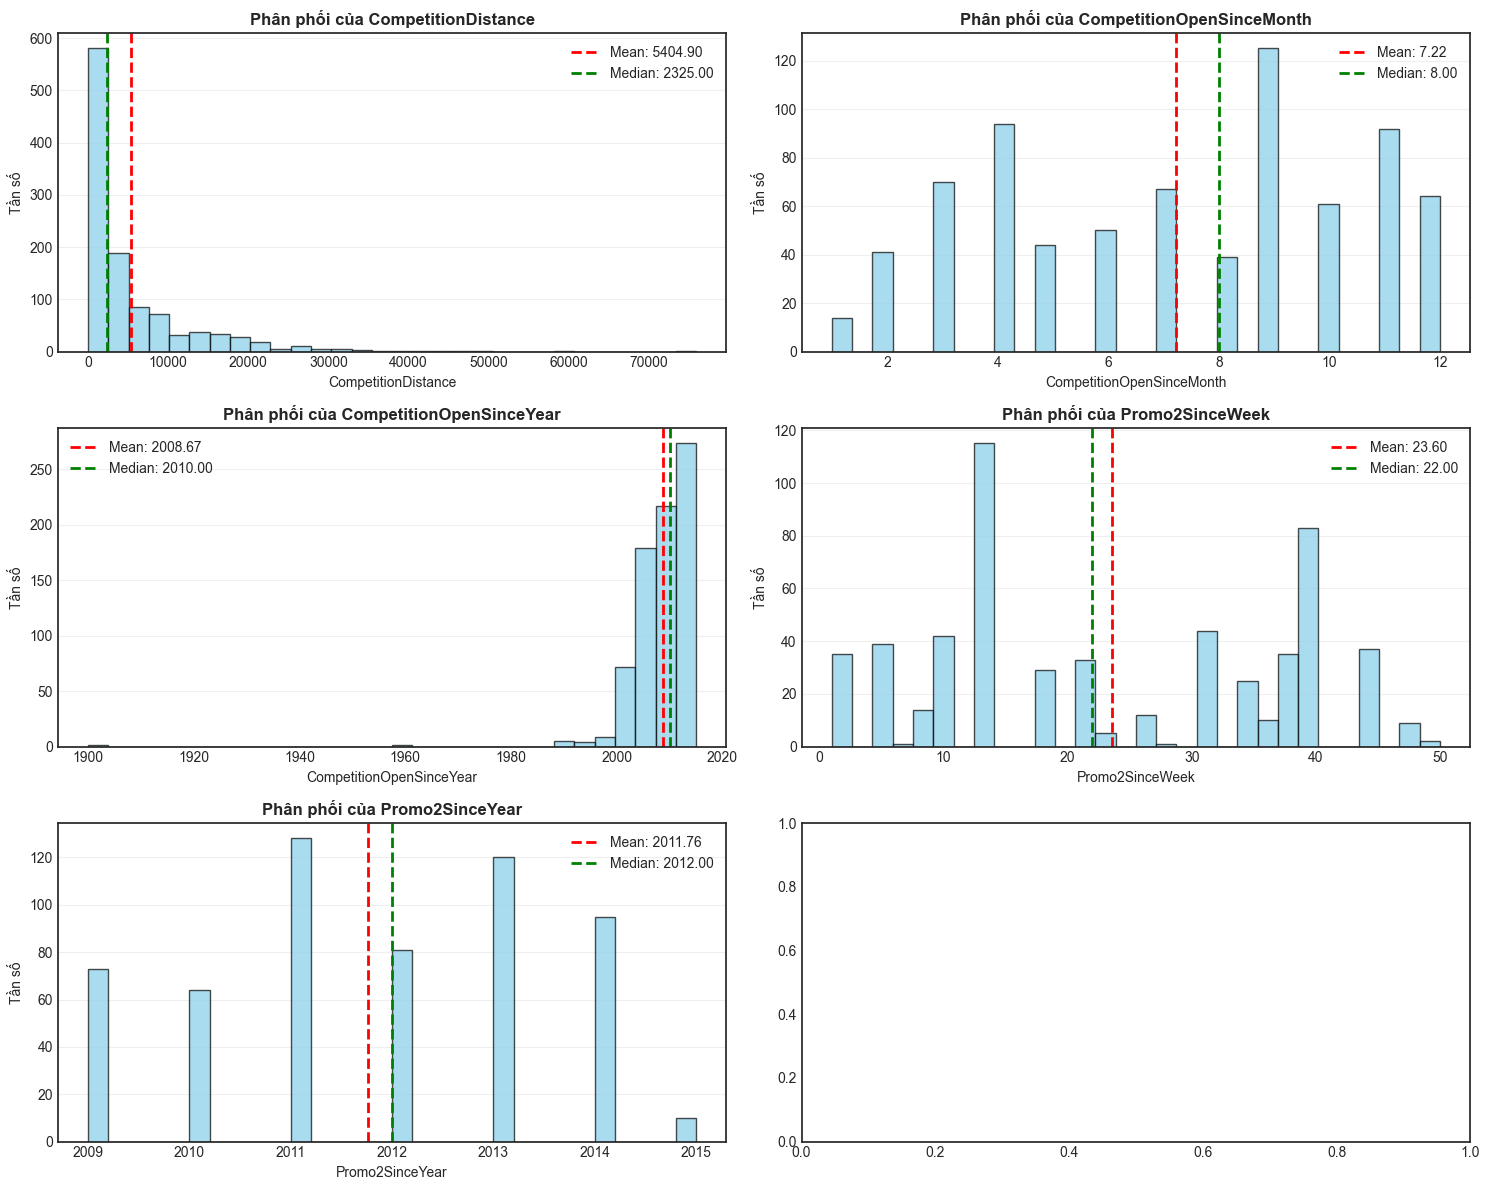

In [283]:
# Vẽ biểu đồ phân phối cho các biến numerical trong df_store
numerical_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                  'Promo2SinceWeek', 'Promo2SinceYear']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    # Lọc bỏ giá trị NaN để vẽ
    data = df_store[col].dropna()
    
    # Vẽ histogram với KDE
    axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'Phân phối của {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Tần số')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm thống kê cơ bản
    mean_val = data.mean()
    median_val = data.median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

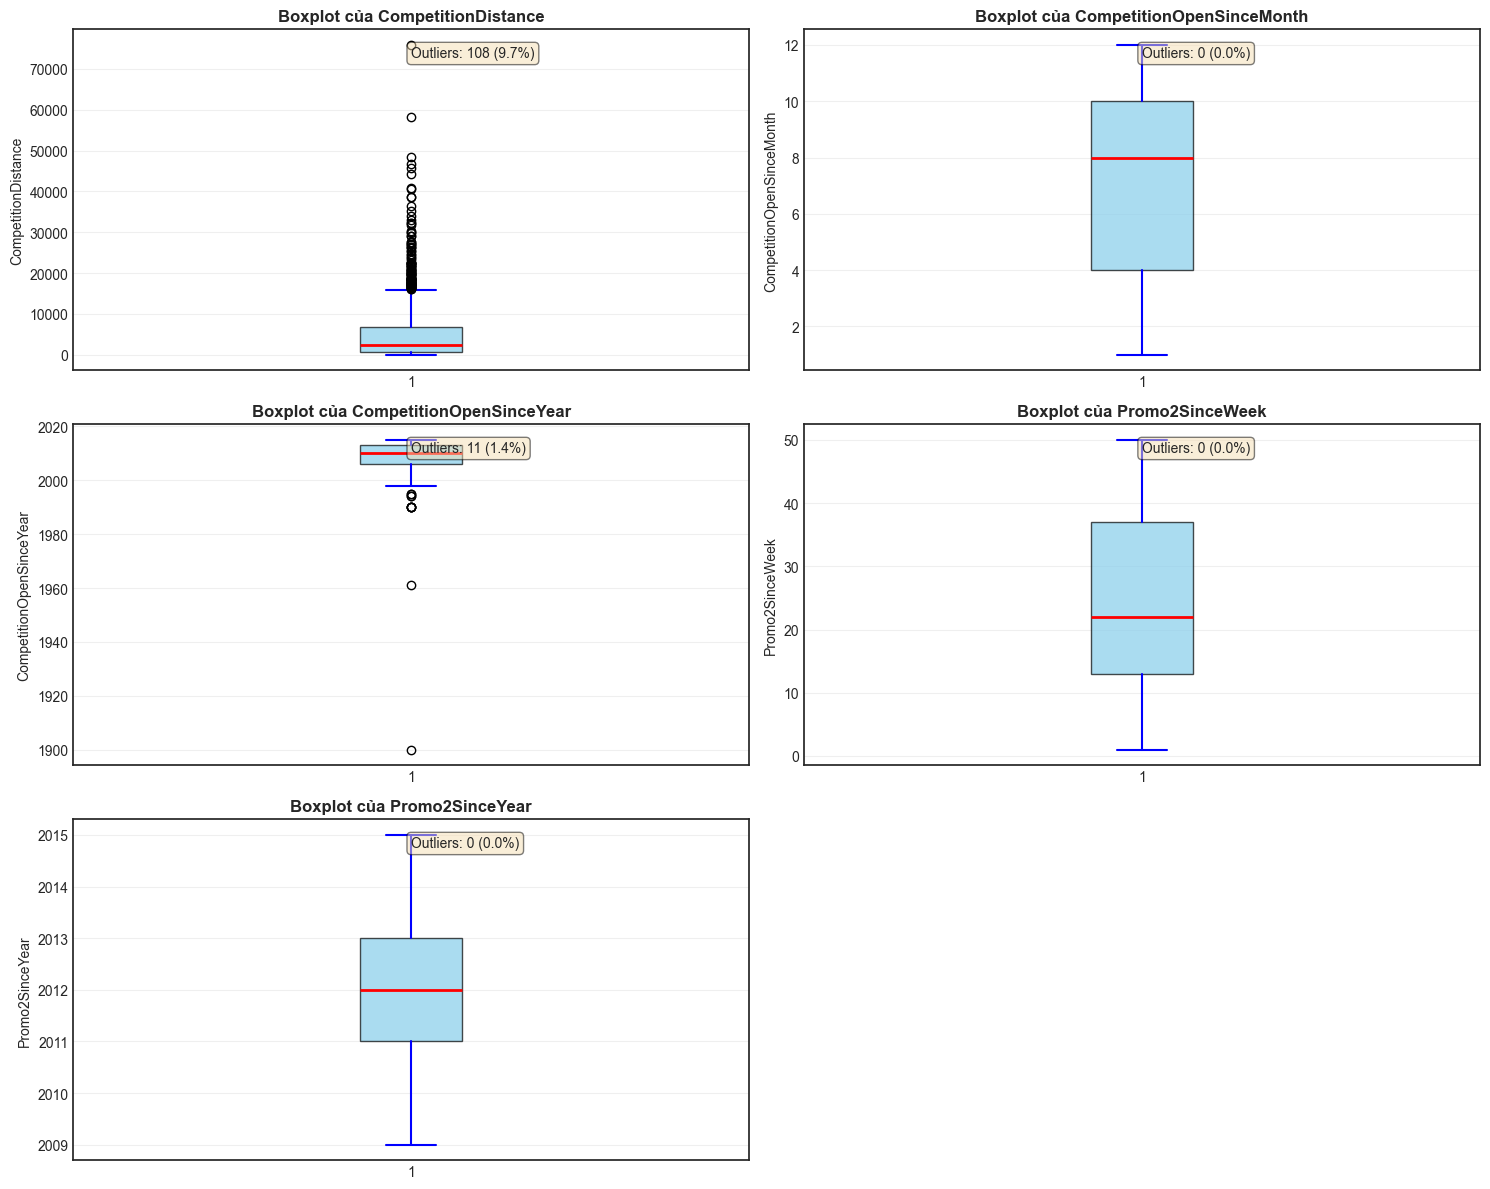

In [284]:
# Vẽ boxplot cho các biến numerical trong df_store
numerical_cols_boxplot = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 
                          'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols_boxplot):
    # Lọc bỏ giá trị NaN để vẽ
    data = df_store[col].dropna()
    
    # Vẽ boxplot
    axes[idx].boxplot(data, vert=True, patch_artist=True,
                     boxprops=dict(facecolor='skyblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5))
    
    axes[idx].set_title(f'Boxplot của {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm thống kê về outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    axes[idx].text(0.5, 0.95, f'Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)',
                  transform=axes[idx].transAxes, fontsize=10,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Ẩn subplot thừa
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

1. Biến `CompetitionDistance`: Biểu đồ dồn cục cực lớn ở phía bên trái (khoảng cách ngắn) và kéo cái đuôi dài tít tắp về phía bên phải cho thấy có rất nhiều cửa hàng Rossmann có đối thủ cạnh tranh ở rất gần (thường < 1km hoặc < 3km). Mặc dù không xét đến missing value nhưng ta vẫn thấy outlier khá nhiều, đây là các cửa hàng rất xa so với các dữ liệu khác. Điều này phản ánh chiến lược chọn địa điểm của Rossmann là đánh vào các khu đông dân cư, trung tâm sầm uất.

2. Biến `CompetitionOpenSinceYear`: Đa số dữ liệu dồn vào khoảng năm 2000 - 2015 bên cạnh đó vẫn có một vài giá trị rất nhỏ nằm tít phía xa bên trái (năm 1900, 1961...). Xuất hiện 9 giá trị outlier trong đó có các giá trị như là 1900 và 1960 có vẻ như không hợp lý lắm vì đã quá lâu đời.

3. Biến `CompetitionOpenSinceMonth`: Dữ liệu phân phối khá đều các tháng, không quá chênh lệch, không có outlier.
4. Biến `Promo2SinceWeek`: Cao điểm ở khoảng tuần 13 có thể là do Rossmann có chương trình khuyến mãi thường xuyên vào tuần này, các tuần còn lại phân bố khá đồng đều, không có outlier.
5. Biến `Promo2SinceYear`: Dữ liệu phân phối khá đều các năm, không quá chênh lệch, không có outlier. Năm 2015 quan sát được có vẻ thấp hơn các năm còn lại có thể là do dữ liệu thu thập mới chỉ đến tháng 7 chưa hết năm 2015.


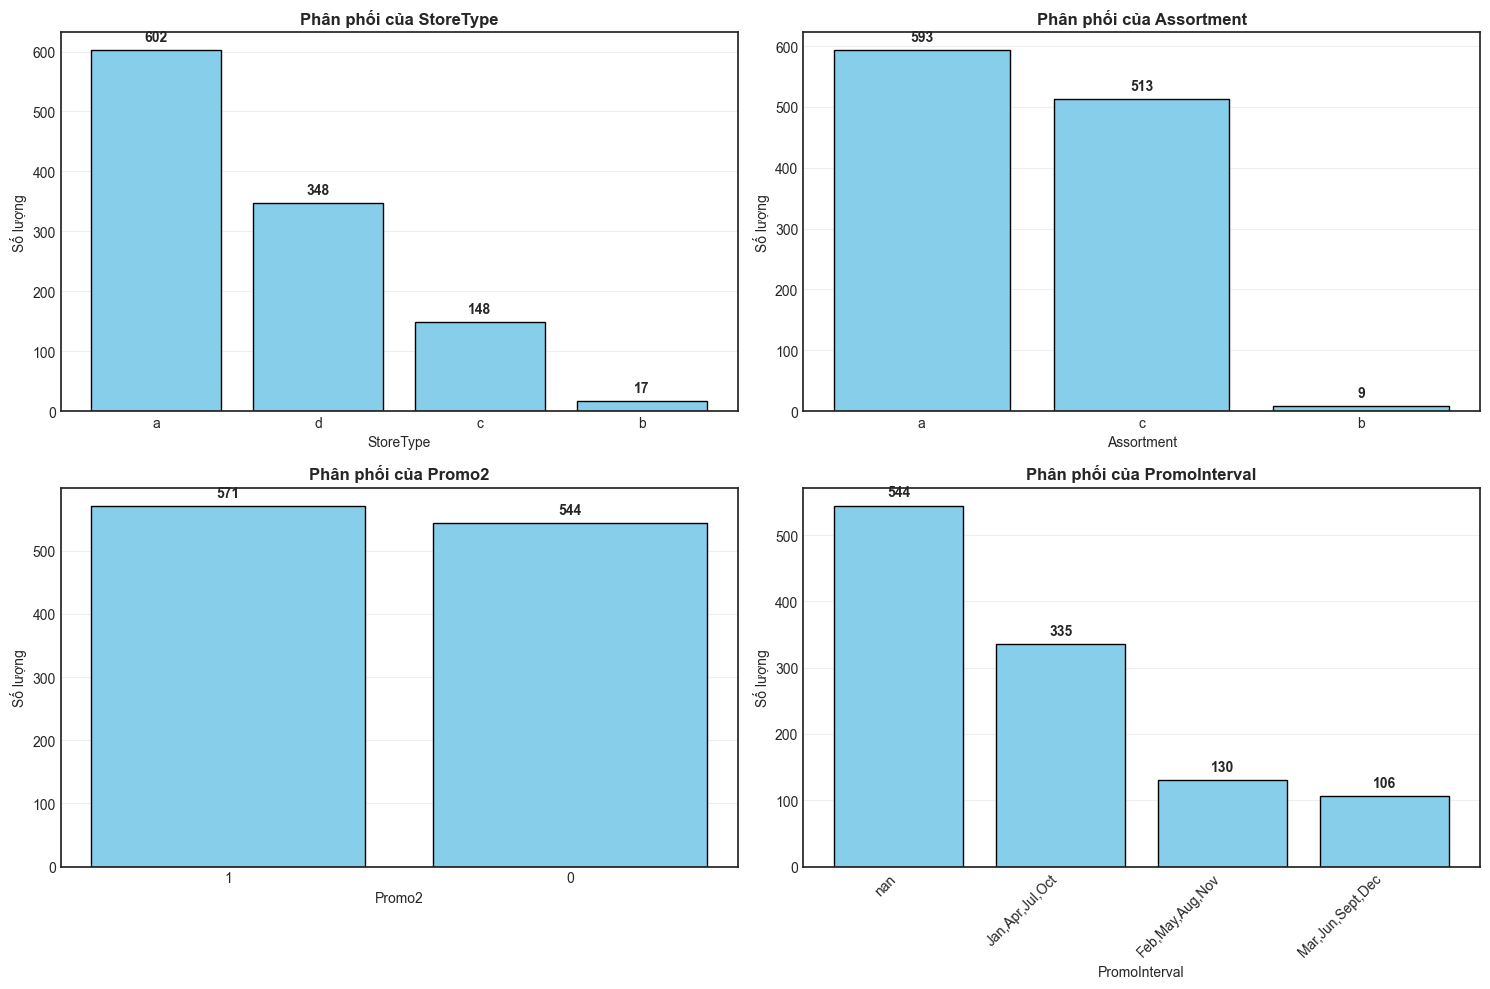

In [285]:
# Vẽ countplot cho các biến categorical và biến nhị phân còn lại trong df_store
categorical_cols = ['StoreType', 'Assortment', 'Promo2', 'PromoInterval']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if col == 'PromoInterval':
        # Đếm các giá trị bao gồm cả NaN
        value_counts = df_store[col].value_counts(dropna=False)
        # Vẽ countplot
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='skyblue', edgecolor='black')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    else:
        # Đếm các giá trị
        value_counts = df_store[col].value_counts()
        # Vẽ countplot
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='skyblue', edgecolor='black')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index)
    
    axes[idx].set_title(f'Phân phối của {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [286]:
# Đếm số loại cửa hàng loại b đồng thời có assortment b
count_b_storetype_assortment_b = df_store[(df_store['StoreType'] == 'b') & (df_store['Assortment'] == 'b')].shape[0]
count_b_storetype_assortment_b

9

1. Dữ liệu rất mất cân bằng khi ở cả 2 biến `StoreType` và `Assortment` dữ liệu về giá trị b rất ít so với các giá trị còn lại và chỉ chiếm khoảng 1%.

2. Biến `Promo2` phân phối rất đều số lượng cửa hàng áp dụng `Promo2` và không áp dụng xấp xỉ nhau.

3. Biến `PromoInterval` có rất nhiều dữ liệu thiếu, có thể là do các cửa hàng không tham gia chương trình khuyến mãi dài hạn này. Trong số các cửa hàng có thông tin về khoảng thời gian khuyến mãi, các khoảng thời gian phổ biến nhất là "Jan, Apr, Jul, Oct" và "Feb, May, Aug, Nov".

4. Tất cả `Assortment b` đều là `StoreType b`

#### Bộ dữ liệu `train.csv`


In [287]:
# Create a copy of the train dataframe for further analysis
df_train = train.copy()


In [288]:
# Xử lí sơ bộ dữ liệu train.csv để phục vụ cho việc phân tích
# Bước 1: Chuyển hết về chuỗi (string) để trộn '0' và 0 lại với nhau
df_train['StateHoliday'] = df_train['StateHoliday'].astype(str)
# Bước 2: Chuyển sang Category
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')
# 


In [289]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  category      
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(7)
memory usage: 63.1 MB


In [290]:
df_train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

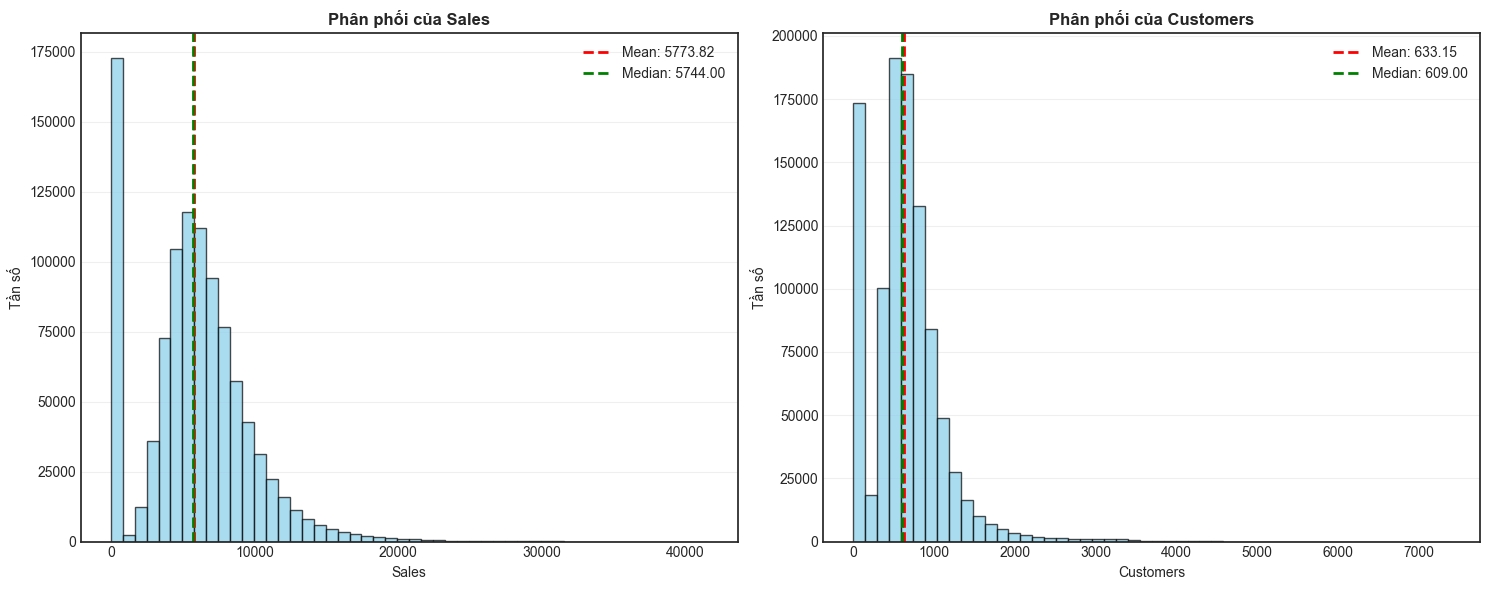

In [291]:
# Vẽ biểu đồ phân phối cho các biến numerical trong df_train
numerical_cols_train = ['Sales', 'Customers']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, col in enumerate(numerical_cols_train):
    data = df_train[col]
    
    # Vẽ histogram với KDE
    axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'Phân phối của {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Tần số')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm thống kê cơ bản
    mean_val = data.mean()
    median_val = data.median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [292]:
df_train[df_train['Sales']==0].shape[0]

172871

In [293]:
df_train[df_train['Customers']==0].shape[0]

172869

In [294]:
df_train[df_train['Open']==0].shape[0]

172817

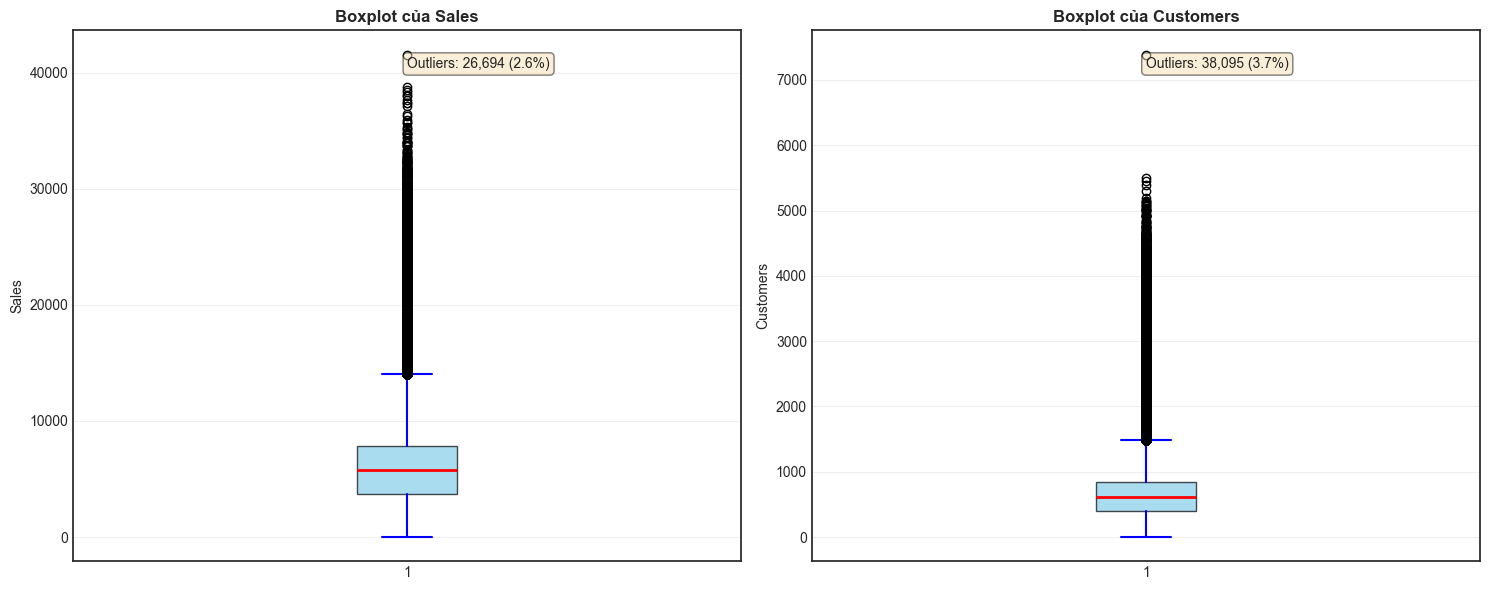

In [295]:
numerical_cols_train_boxplot = ['Sales', 'Customers']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, col in enumerate(numerical_cols_train_boxplot):
    # Lọc bỏ giá trị 0 để vẽ boxplot rõ hơn
    data = df_train[col] #[df_train[col] > 0][col]
    
    # Vẽ boxplot
    axes[idx].boxplot(data, vert=True, patch_artist=True,
                     boxprops=dict(facecolor='skyblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5))
    
    axes[idx].set_title(f'Boxplot của {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm thống kê về outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    axes[idx].text(0.5, 0.95, f'Outliers: {len(outliers):,} ({len(outliers)/len(data)*100:.1f}%)',
                  transform=axes[idx].transAxes, fontsize=10,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

1. Cả 2 biến `Sales` và `Customers` đều có thể coi là 2 biến mục tiêu của dự án này, dựa trên phân phối ta thấy chúng có hình dạng rất tương đồng với nhau

2. Dữ liệu của cả 2 biến có dấu hiệu lệch phải khá rõ rệt. Điều này cho thấy trong hầu hết các ngày, doanh số bán hàng và lượng khách hàng đến cửa hàng thường ở mức thấp đến trung bình, trong khi chỉ có một số ít ngày đạt doanh số và lượng khách hàng rất cao.

3. Phần outlier quan sát được ở cả 2 biến lần lượt chiếm 3.6% và 4.8% tổng dữ liệu, cho thấy có một số ngày đặc biệt mà doanh số và lượng khách hàng tăng vọt, có thể do các sự kiện đặc biệt, khuyến mãi lớn hoặc các dịp lễ hội.

4. Có một số lượng lớn ngày doanh số bán hàng và lượng khách hàng bằng 0, điều này có thể do cửa hàng đóng cửa vào những ngày đó (ví dụ như Chủ nhật hoặc các ngày lễ lớn).

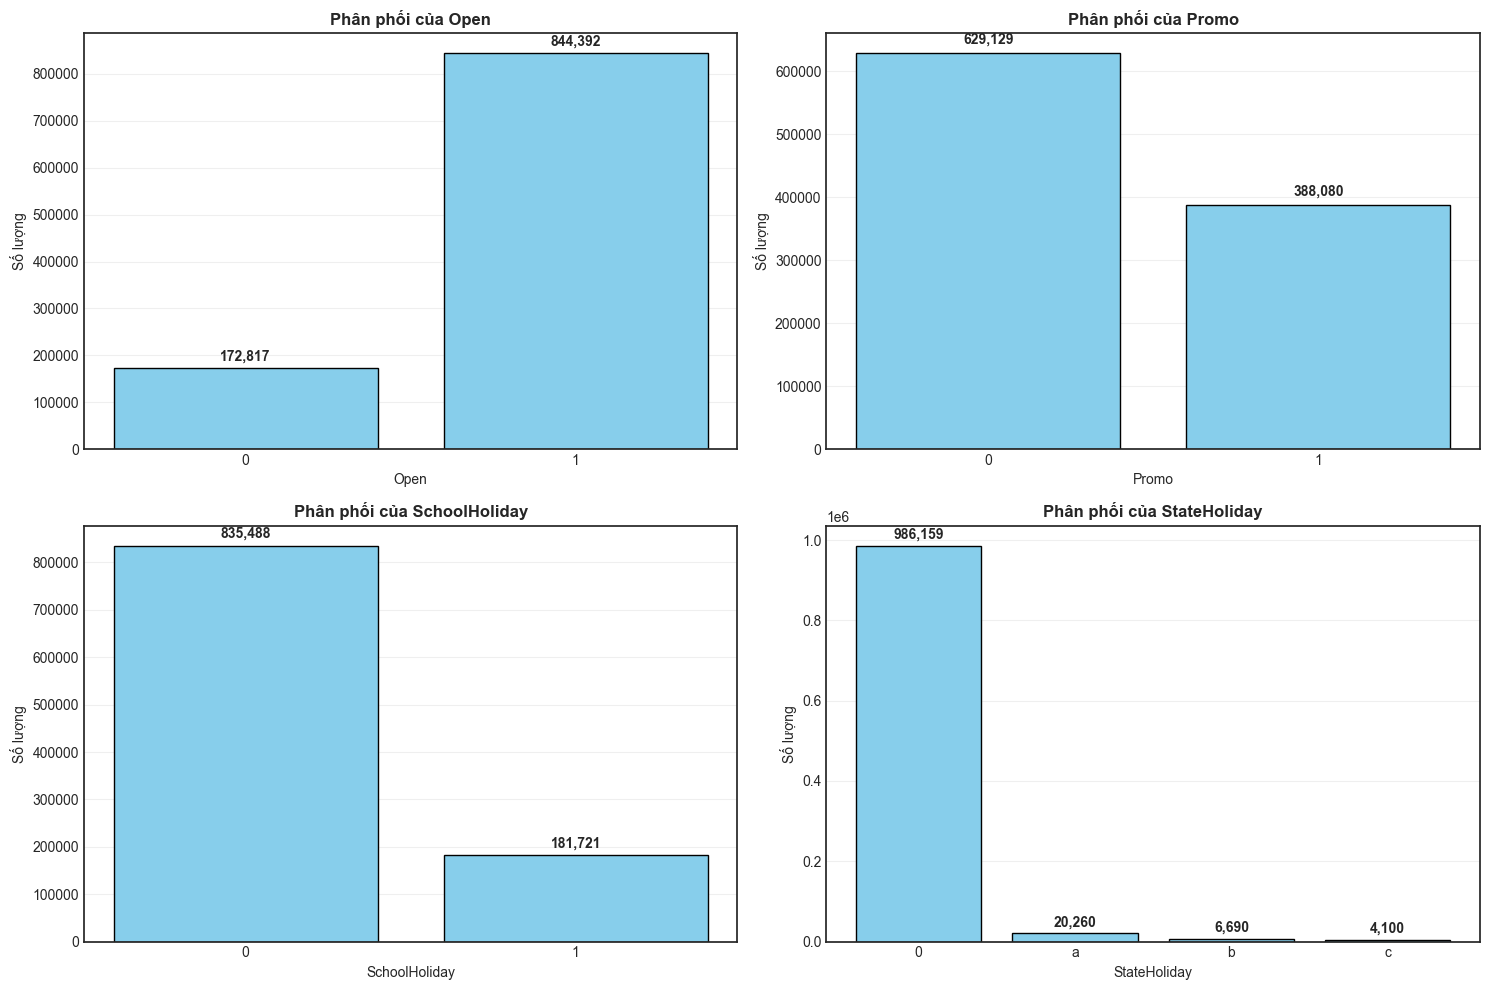

In [296]:
# Vẽ countplot cho các biến nhị phân và categorical trong df_train
binary_categorical_cols = ['Open', 'Promo', 'SchoolHoliday', 'StateHoliday']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(binary_categorical_cols):
    # Đếm các giá trị
    value_counts = df_train[col].value_counts().sort_index()
    
    # Vẽ countplot
    axes[idx].bar(range(len(value_counts)), value_counts.values, color='skyblue', edgecolor='black')
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index)
    
    axes[idx].set_title(f'Phân phối của {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v + 10000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

1. Cửa hàng có tỉ lệ mở cửa rất cao, điều này hợp lí vì các cửa hàng Rossmann thường mở cửa hầu hết các ngày trong tuần, chỉ đóng cửa vào những ngày lễ lớn hoặc Chủ nhật.

2. Tần suất chạy các chương trình khuyến mãi ngắn hạn (`Promo`) khá thường xuyên, chiếm khoảng 38% tổng số ngày kinh doanh.

3. Số ngày nghỉ học (`SchoolHoliday`) chiếm khoảng 22% tổng số ngày, điều này có thể ảnh hưởng đến lượng khách hàng, đặc biệt là các gia đình có con em đi học.

4. Dữ liệu của biến `StateHoliday` mất cân bằng rất nghiêm trọng khi đa số các ngày không phải là ngày lễ (giá trị '0'), trong khi các ngày lễ xuất hiện rất ít, đặc biệt là các ngày lễ loại b và c, còn loại a thì phổ biến hơn nhưng vẫn chiếm tỉ lệ rất nhỏ so với tổng số ngày.

#### Kết luận phân tích đơn biến


<b> 1. Các biến liên quan đến đối thủ </b>
- Phần lớn các cửa hàng có đối thủ nằm ở khoảng cách rất gần (dưới 1–3 km) nhưng vẫn còn outlier khá nhiều, đây là các cửa hàng rất xa so với các dữ liệu khác, thể hiện rõ chiến lược tập trung và mở rộng tại các khu dân cư đông đúc, trung tâm thương mại.

- Các giá trị outlier như năm 1900, 1961 trong `CompetitionOpenSinceYear` trông có vẻ không thực tế vì khá lâu đời rồi.

<b> 2. Các biến liên quan đến promotion </b>
- Tần suất chạy `Promo` (khuyến mãi ngắn hạn) chiếm đến 38% ngày hoạt động, chứng tỏ promotion là chiến lược kinh doanh chủ lực của Rossmann.

- Khoảng một nửa cửa hàng tham gia `Promo2`,

- Biến `PromoInterval` có rất nhiều dữ liệu thiếu, có thể là do các cửa hàng không tham gia chương trình khuyến mãi dài hạn này. Trong số các cửa hàng có thông tin về khoảng thời gian khuyến mãi, các khoảng thời gian phổ biến nhất là "Jan, Apr, Jul, Oct" và "Feb, May, Aug, Nov".

<b> 3. Vấn đề mất cân bằng dữ liệu </b>
- Các loại `StoreType` và `Assortment` có giá trị hiếm (loại b) chiếm chưa tới 1% thể sự mất cân bằng dữ liệu rất mạnh

- Biến `StateHoliday` cực kỳ mất cân bằng khi hầu hết các ngày không phải lễ, khiến các giá trị a, b, c có thể đóng góp thông tin nhưng cần kỹ thuật xử lý để mô hình hiểu được.

### <b>Phân tích 2 biến</b>

#### Phân tích

In [297]:
# Gộp dữ liệu train và store để phân tích mối quan hệ giữa các biến
df_merged = pd.merge(df_train, df_store, on='Store', how='inner')

In [298]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  category      
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  category      
 10  Assortment                 1017209 non-null  category      
 11  CompetitionDistance        1014567 no

In [299]:
# Biến Date thành index
df_merged.set_index('Date', inplace=True)
# Trích xuất các đặc trưng thời gian từ cột Date
df_merged['Year'] = df_merged.index.year
df_merged['Month'] = df_merged.index.month
df_merged['Day'] = df_merged.index.day
df_merged['WeekOfYear'] = df_merged.index.isocalendar().week

# Thêm biến SalePerCustomer
df_merged['SalePerCustomer'] = df_merged['Sales']/df_merged['Customers']


In [300]:
df_merged.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
SalePerCustomer              172869
dtype: int64

> Các nhóm biến có liên quan đến biến `Promo2` và các nhốm biến liên quan đến biến `Competition` đều có số lượng missing value khá lớn, trong khi các biến còn lại không có missing value nào. Do đó chúng ta sẽ tìm hiểu xem lý do tại sao các biến này lại có nhiều missing value như vậy.


In [301]:
df_merged[df_merged['CompetitionDistance'].isnull()].head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    291          5  10052        973     1      1            0   
2015-07-31    622          5   6306        540     1      1            0   
2015-07-31    879          5   6000        466     1      1            0   
2015-07-30    291          4   9030        883     1      1            0   
2015-07-30    622          4   5412        406     1      1            0   

            SchoolHoliday StoreType Assortment  ...  CompetitionOpenSinceYear  \
Date                                            ...                             
2015-07-31              1         d          a  ...                       NaN   
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              0         d          a  ...                       NaN   
2015-07-30              1         d          a  ...                       NaN   
2015-07-30              1         a          c  ...                       NaN   

            Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  \
Date                                                                          
2015-07-31       0              NaN              NaN              NaN  2015   
2015-07-31       0              NaN              NaN              NaN  2015   
2015-07-31       1              5.0           2013.0  Feb,May,Aug,Nov  2015   
2015-07-30       0              NaN              NaN              NaN  2015   
2015-07-30       0              NaN              NaN              NaN  2015   

           Month  Day  WeekOfYear  SalePerCustomer  
Date                                                
2015-07-31     7   31          31        10.330935  
2015-07-31     7   31          31        11.677778  
2015-07-31     7   31          31        12.875536  
2015-07-30     7   30          31        10.226501  
2015-07-30     7   30          31        13.330049  

[5 rows x 22 columns]

In [302]:
df_merged[df_merged['CompetitionOpenSinceMonth'].isnull()].head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31     12          5   8959        962     1      1            0   
2015-07-31     13          5   8821        568     1      1            0   
2015-07-31     16          5  10231        979     1      1            0   
2015-07-31     19          5   8234        718     1      1            0   
2015-07-31     22          5   6566        633     1      1            0   

            SchoolHoliday StoreType Assortment  ...  CompetitionOpenSinceYear  \
Date                                            ...                             
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              0         d          a  ...                       NaN   
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              0         a          a  ...                       NaN   

            Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval  Year  \
Date                                                                           
2015-07-31       1             13.0           2010.0   Jan,Apr,Jul,Oct  2015   
2015-07-31       1             45.0           2009.0   Feb,May,Aug,Nov  2015   
2015-07-31       0              NaN              NaN               NaN  2015   
2015-07-31       1             22.0           2011.0  Mar,Jun,Sept,Dec  2015   
2015-07-31       1             22.0           2012.0   Jan,Apr,Jul,Oct  2015   

           Month  Day  WeekOfYear  SalePerCustomer  
Date                                                
2015-07-31     7   31          31         9.312890  
2015-07-31     7   31          31        15.529930  
2015-07-31     7   31          31        10.450460  
2015-07-31     7   31          31        11.467967  
2015-07-31     7   31          31        10.372828  

[5 rows x 22 columns]

In [303]:
df_merged[df_merged['CompetitionOpenSinceYear'].isnull()].head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31     12          5   8959        962     1      1            0   
2015-07-31     13          5   8821        568     1      1            0   
2015-07-31     16          5  10231        979     1      1            0   
2015-07-31     19          5   8234        718     1      1            0   
2015-07-31     22          5   6566        633     1      1            0   

            SchoolHoliday StoreType Assortment  ...  CompetitionOpenSinceYear  \
Date                                            ...                             
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              0         d          a  ...                       NaN   
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              1         a          c  ...                       NaN   
2015-07-31              0         a          a  ...                       NaN   

            Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval  Year  \
Date                                                                           
2015-07-31       1             13.0           2010.0   Jan,Apr,Jul,Oct  2015   
2015-07-31       1             45.0           2009.0   Feb,May,Aug,Nov  2015   
2015-07-31       0              NaN              NaN               NaN  2015   
2015-07-31       1             22.0           2011.0  Mar,Jun,Sept,Dec  2015   
2015-07-31       1             22.0           2012.0   Jan,Apr,Jul,Oct  2015   

           Month  Day  WeekOfYear  SalePerCustomer  
Date                                                
2015-07-31     7   31          31         9.312890  
2015-07-31     7   31          31        15.529930  
2015-07-31     7   31          31        10.450460  
2015-07-31     7   31          31        11.467967  
2015-07-31     7   31          31        10.372828  

[5 rows x 22 columns]

Quan sát thấy khi biến `CompetitionDistance` có missing value thì các biến `CompetitionOpenSinceMonth` và `CompetitionOpenSinceYear` cũng đều có missing value tương ứng. Điều này cho thấy các cửa hàng không có đối thủ cạnh tranh gần thì cũng không có thông tin về thời gian mở cửa của đối thủ.
Tuy nhiên khi biến `CompetitionOpenSinceMonth` và `CompetitionOpenSinceYear` có missing value thì biến `CompetitionDistance` không nhất thiết phải missing value. Điều này có thể do thông tin thực sự bị thiếu do không thu thập được dữ liệu từ các cửa hàng đối thủ cạnh tranh.

_Có lẽ cũng tương tự đối với các biến liên quan đến Promo2, khi biến Promo2 có giá trị 0 thì các biến Promo2SinceWeek và Promo2SinceYear sẽ có missing value vì cửa hàng không tham gia chương trình khuyến mãi dài hạn này ?_


In [304]:
df_merged[df_merged['Promo2'] == 0][['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].isnull().sum()

Promo2SinceWeek    508031
Promo2SinceYear    508031
PromoInterval      508031
dtype: int64

Số lượng missing value của các biến liên quan đến `Promo2` khi biến `Promo2 = 0` thực sự bằng số lượng missing value của các biến này trong toàn bộ dữ liệu, vì vậy giả thuyết trên là đúng.

_Biến `SalePerCustomer` có số lượng missing value lớn, có thể là do dữ liệu các ngày không có khách hàng (`Customers = 0`) dẫn đến việc không thể tính toán được doanh thu trên mỗi khách hàng?_


In [305]:
df_merged[(df_merged['Customers']==0) & df_merged['SalePerCustomer'].isnull()]


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    292          5      0          0     0      1            0   
2015-07-31    876          5      0          0     0      1            0   
2015-07-30    292          4      0          0     0      1            0   
2015-07-30    876          4      0          0     0      1            0   
2015-07-29    292          3      0          0     0      1            0   
...           ...        ...    ...        ...   ...    ...          ...   
2013-01-01   1111          2      0          0     0      0            a   
2013-01-01   1112          2      0          0     0      0            a   
2013-01-01   1113          2      0          0     0      0            a   
2013-01-01   1114          2      0          0     0      0            a   
2013-01-01   1115          2      0          0     0      0            a   

            SchoolHoliday StoreType Assortment  ...  CompetitionOpenSinceYear  \
Date                                            ...                             
2015-07-31              1         a          a  ...                    2009.0   
2015-07-31              1         a          a  ...                    2005.0   
2015-07-30              1         a          a  ...                    2009.0   
2015-07-30              1         a          a  ...                    2005.0   
2015-07-29              1         a          a  ...                    2009.0   
...                   ...       ...        ...  ...                       ...   
2013-01-01              1         a          a  ...                    2014.0   
2013-01-01              1         c          c  ...                    2006.0   
2013-01-01              1         a          c  ...                       NaN   
2013-01-01              1         a          c  ...                       NaN   
2013-01-01              1         d          c  ...                       NaN   

            Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval  Year  \
Date                                                                           
2015-07-31       0              NaN              NaN               NaN  2015   
2015-07-31       1             18.0           2015.0   Feb,May,Aug,Nov  2015   
2015-07-30       0              NaN              NaN               NaN  2015   
2015-07-30       1             18.0           2015.0   Feb,May,Aug,Nov  2015   
2015-07-29       0              NaN              NaN               NaN  2015   
...            ...              ...              ...               ...   ...   
2013-01-01       1             31.0           2013.0   Jan,Apr,Jul,Oct  2013   
2013-01-01       0              NaN              NaN               NaN  2013   
2013-01-01       0              NaN              NaN               NaN  2013   
2013-01-01       0              NaN              NaN               NaN  2013   
2013-01-01       1             22.0           2012.0  Mar,Jun,Sept,Dec  2013   

           Month  Day  WeekOfYear  SalePerCustomer  
Date                                                
2015-07-31     7   31          31              NaN  
2015-07-31     7   31          31              NaN  
2015-07-30     7   30          31              NaN  
2015-07-30     7   30          31              NaN  
2015-07-29     7   29          31              NaN  
...          ...  ...         ...              ...  
2013-01-01     1    1           1              NaN  
2013-01-01     1    1           1              NaN  
2013-01-01     1    1           1              NaN  
2013-01-01     1    1           1              NaN  
2013-01-01     1    1           1              NaN  

[172869 rows x 22 columns]

Có 172869 dòng có `Customers = 0` và `SalePerCustomer = null` đúng bằng số lượng missing value của biến `SalePerCustomer` vì vậy điều đó là đúng.

_Ở phần data understanding, chúng ta có quan sát được có những ngày cửa hàng có `sales = 0` và `customer = 0`. Có phải chăng toàn bộ những ngày có `sales = 0` và `customer = 0` đều là những ngày cửa hàng đóng cửa (`open = 0`)?_


In [306]:
print(f"Số lượng ngày có Sales = 0: {(df_merged['Sales'] == 0).sum()}")
print(f"Số lượng ngày có Customers = 0: {(df_merged['Customers'] == 0).sum()}")
print(f"Số lượng ngày có Sales = 0 và Open = 0: {((df_merged['Sales'] == 0) & (df_merged['Open'] == 0)).sum()}")

Số lượng ngày có Sales = 0: 172871
Số lượng ngày có Customers = 0: 172869
Số lượng ngày có Sales = 0 và Open = 0: 172817


In [307]:
# Đếm xem có bao nhiều ngày mở cửa nhưng không có khách
print(f"Số ngày mở cửa nhưng không có khách: {df_merged[(df_merged['Open']==1) & (df_merged['Customers']==0)].shape[0]}")

Số ngày mở cửa nhưng không có khách: 52


In [308]:
print(f"Số ngày có khách hàng nhưng không có sale: {df_merged[(df_merged['Customers']!=0) & (df_merged['Sales']==0)].shape[0]}")

Số ngày có khách hàng nhưng không có sale: 2


> Vậy là không phải tất cả các ngày có `sales = 0` và `customers = 0` đều là những ngày cửa hàng đóng cửa (`open = 0`). Có 52 ngày cửa hàng mở cửa nhưng không có khách hàng nào đến mua sắm, dẫn đến doanh số bán hàng bằng 0 và 2 ngày có khách hàng nhưng không bán được sản phẩm nào. 
> Số ngày mở cửa (`open = 1`) nhưng không có khách và có khách nhưng không bán được quá ít so với dataset nên không tìm thấy có pattern, có thể suy đoán do 1 số lý do đặc biệt nào đó như là những ngày cửa hàng đóng cửa nhưng `open` lại ghi nhận là 1 do lỗi dữ liệu, hoặc thực sự cửa hàng có mở cửa nhưng không có khách hàng nào đến mua sắm vào những ngày đó.


_Tiếp đến chúng ta sẽ xem doanh thu của các cửa hàng theo thời gian_


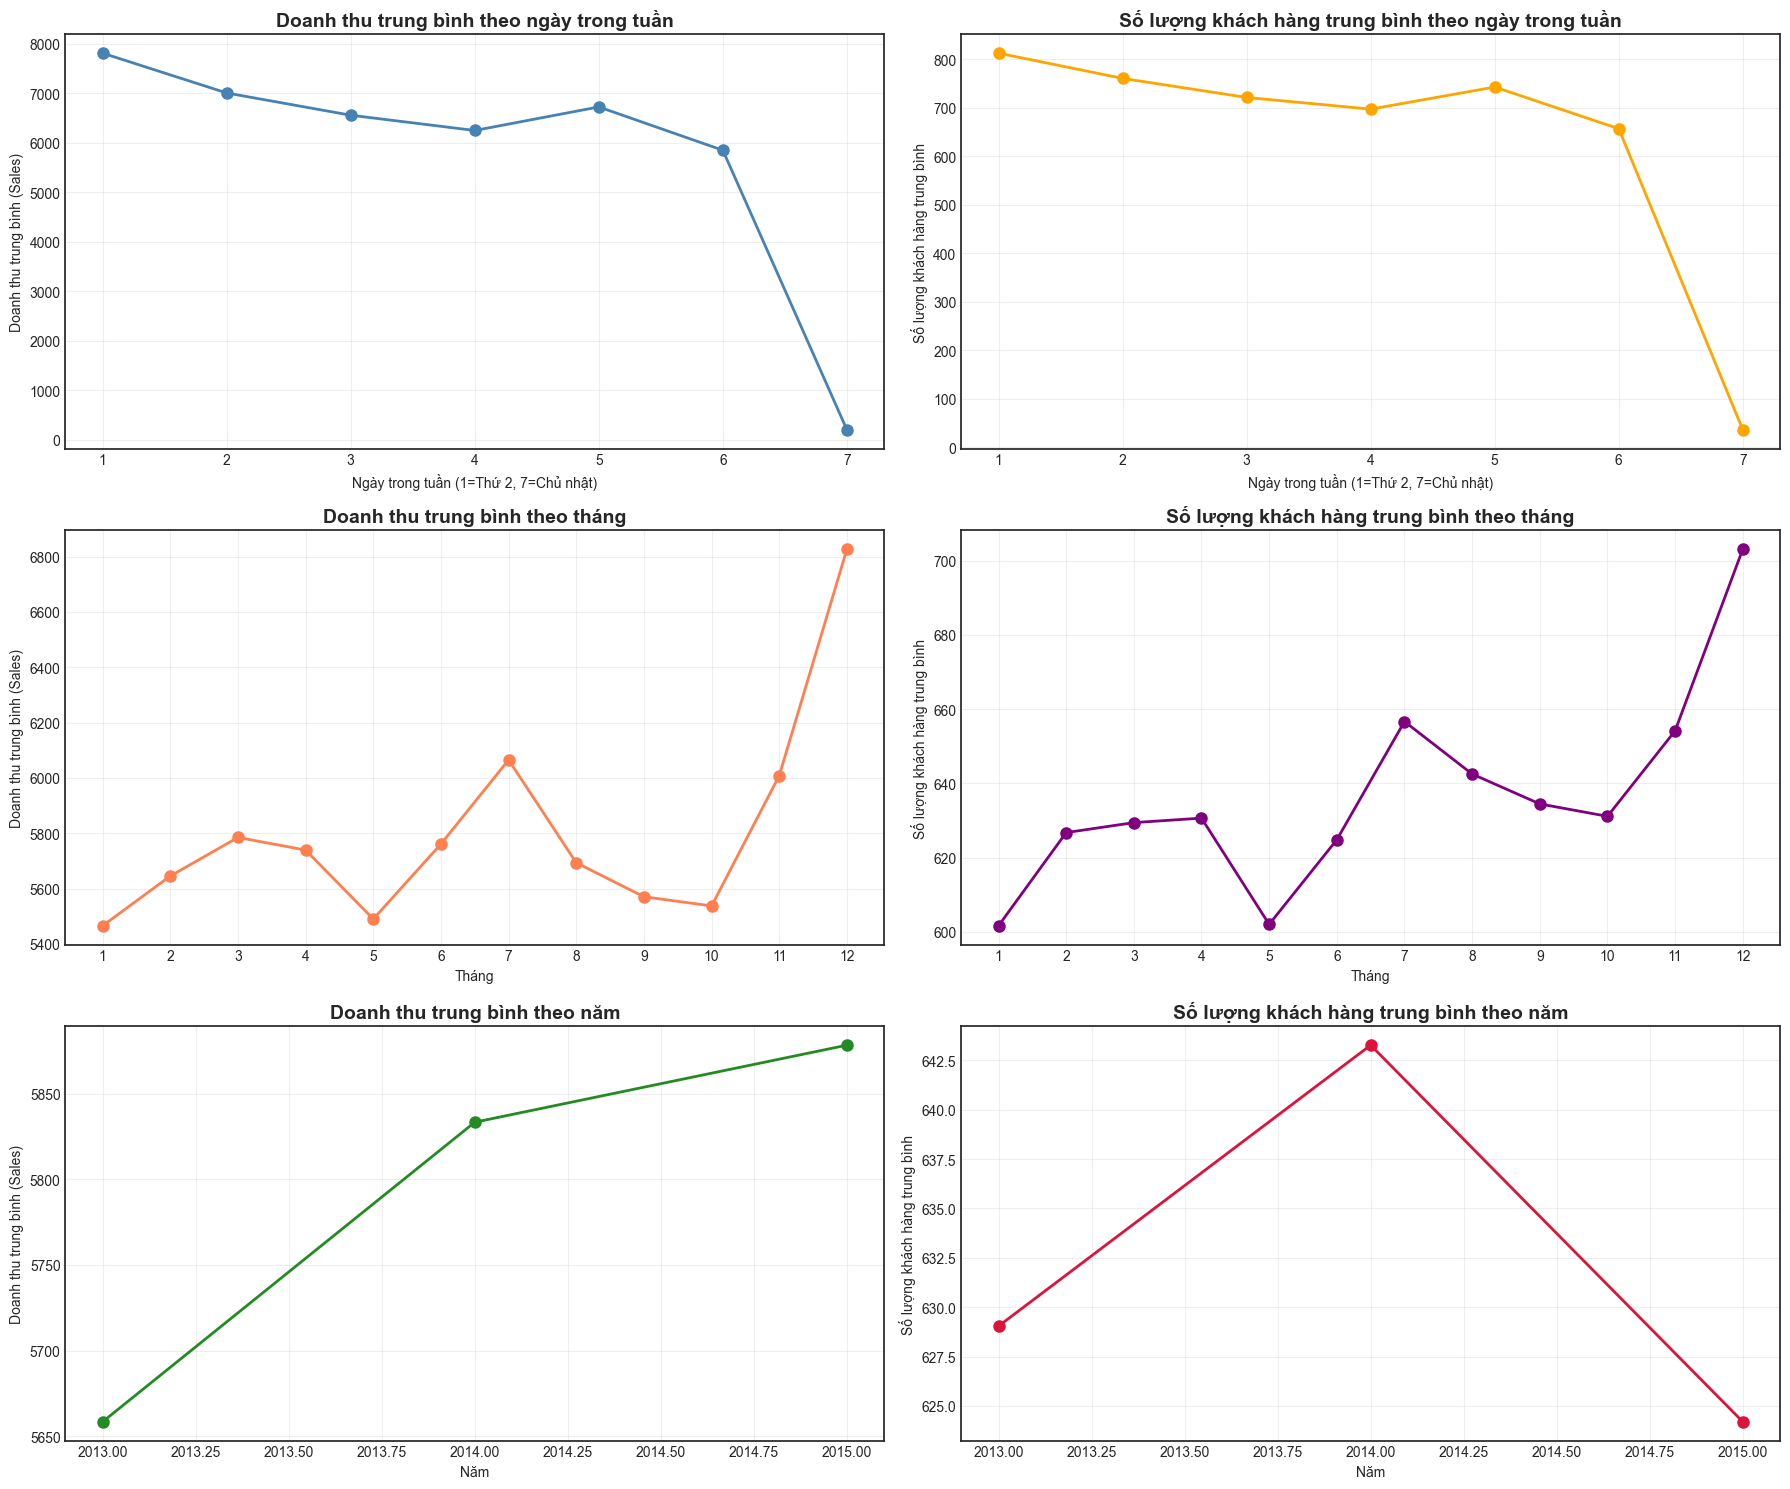

In [309]:
# Vẽ biểu đồ doanh thu và số lượng khách hàng theo ngày, tháng, năm
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Doanh thu trung bình theo ngày trong tuần
daily_sales = df_merged.groupby('DayOfWeek')['Sales'].mean()
axes[0, 0].plot(daily_sales.index, daily_sales.values, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_title('Doanh thu trung bình theo ngày trong tuần', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Ngày trong tuần (1=Thứ 2, 7=Chủ nhật)')
axes[0, 0].set_ylabel('Doanh thu trung bình (Sales)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 8))

# Số lượng khách hàng trung bình theo ngày trong tuần
daily_customers = df_merged.groupby('DayOfWeek')['Customers'].mean()
axes[0, 1].plot(daily_customers.index, daily_customers.values, marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_title('Số lượng khách hàng trung bình theo ngày trong tuần', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Ngày trong tuần (1=Thứ 2, 7=Chủ nhật)')
axes[0, 1].set_ylabel('Số lượng khách hàng trung bình')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, 8))

# Doanh thu trung bình theo tháng
monthly_sales = df_merged.groupby('Month')['Sales'].mean()
axes[1, 0].plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2, markersize=8, color='coral')
axes[1, 0].set_title('Doanh thu trung bình theo tháng', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tháng')
axes[1, 0].set_ylabel('Doanh thu trung bình (Sales)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(1, 13))

# Số lượng khách hàng trung bình theo tháng
monthly_customers = df_merged.groupby('Month')['Customers'].mean()
axes[1, 1].plot(monthly_customers.index, monthly_customers.values, marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_title('Số lượng khách hàng trung bình theo tháng', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Tháng')
axes[1, 1].set_ylabel('Số lượng khách hàng trung bình')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(1, 13))

# Doanh thu trung bình theo năm
yearly_sales = df_merged.groupby('Year')['Sales'].mean()
axes[2, 0].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2, markersize=8, color='forestgreen')
axes[2, 0].set_title('Doanh thu trung bình theo năm', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Năm')
axes[2, 0].set_ylabel('Doanh thu trung bình (Sales)')
axes[2, 0].grid(True, alpha=0.3)

# Số lượng khách hàng trung bình theo năm
yearly_customers = df_merged.groupby('Year')['Customers'].mean()
axes[2, 1].plot(yearly_customers.index, yearly_customers.values, marker='o', linewidth=2, markersize=8, color='crimson')
axes[2, 1].set_title('Số lượng khách hàng trung bình theo năm', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Năm')
axes[2, 1].set_ylabel('Số lượng khách hàng trung bình')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [310]:
yearly_summary = df_merged.groupby('Year').agg({
    'Sales': ['mean', 'sum'],
    'Customers': ['mean', 'sum'],
    'SalePerCustomer': 'mean'
}).reset_index()
yearly_summary


Year        Sales               Customers            SalePerCustomer
                mean         sum        mean        sum            mean
0  2013  5658.533675  2302876084  629.043686  256004425        9.366255
1  2014  5833.290704  2180804896  643.268034  240488971        9.432351
2  2015  5878.245380  1389499643  624.199843  147548359        9.810185

1. Có sự tượng đồng rõ rệt trong biểu đồ doanh thu và lượng khách trung bình theo các ngày trong tuần và theo tháng, điều này vô cùng hợp lí vì lượng khách hàng đến cửa hàng sẽ ảnh hưởng trực tiếp đến doanh thu bán hàng.

2. Doanh thu và lượng khách hàng trung bình theo năm có chút không hợp lý khi doanh thu trung bình ở năm 2015 tăng so với các năm trước còn lượng khách hàng trung bình thì lại giảm mặc dù dữ liệu năm 2015 chỉ đến tháng 7, tuy nhiên có thể lý giải 1 phần thông qua `SalePerCustomer` trung bình hàng năm cho thấy vào năm 2015 trung bình mỗi khách hàng mua hàng với giá trị 9.81 dollars cao hơn so với các năm trước (năm 2013 là 9.43 dollars và năm 2014 là 9.36 dollars), từ đó dẫn đến doanh thu trung bình tăng mặc dù lượng khách hàng giảm. 

3. Doanh thu và lượng khách hàng trung bình có sự sụt giảm nghiêm trọng ở các ngày chủ nhật và vào tháng 1 và tháng 5 hàng năm, ngược lại tăng mạnh vào các ngày đầu tuần và vào các tháng cuối năm như tháng 11 và tháng 12. Đây có thể là 1 đặc điểm về tính mùa vụ của cửa hàng Rossmann cần được khai thác sâu hơn.

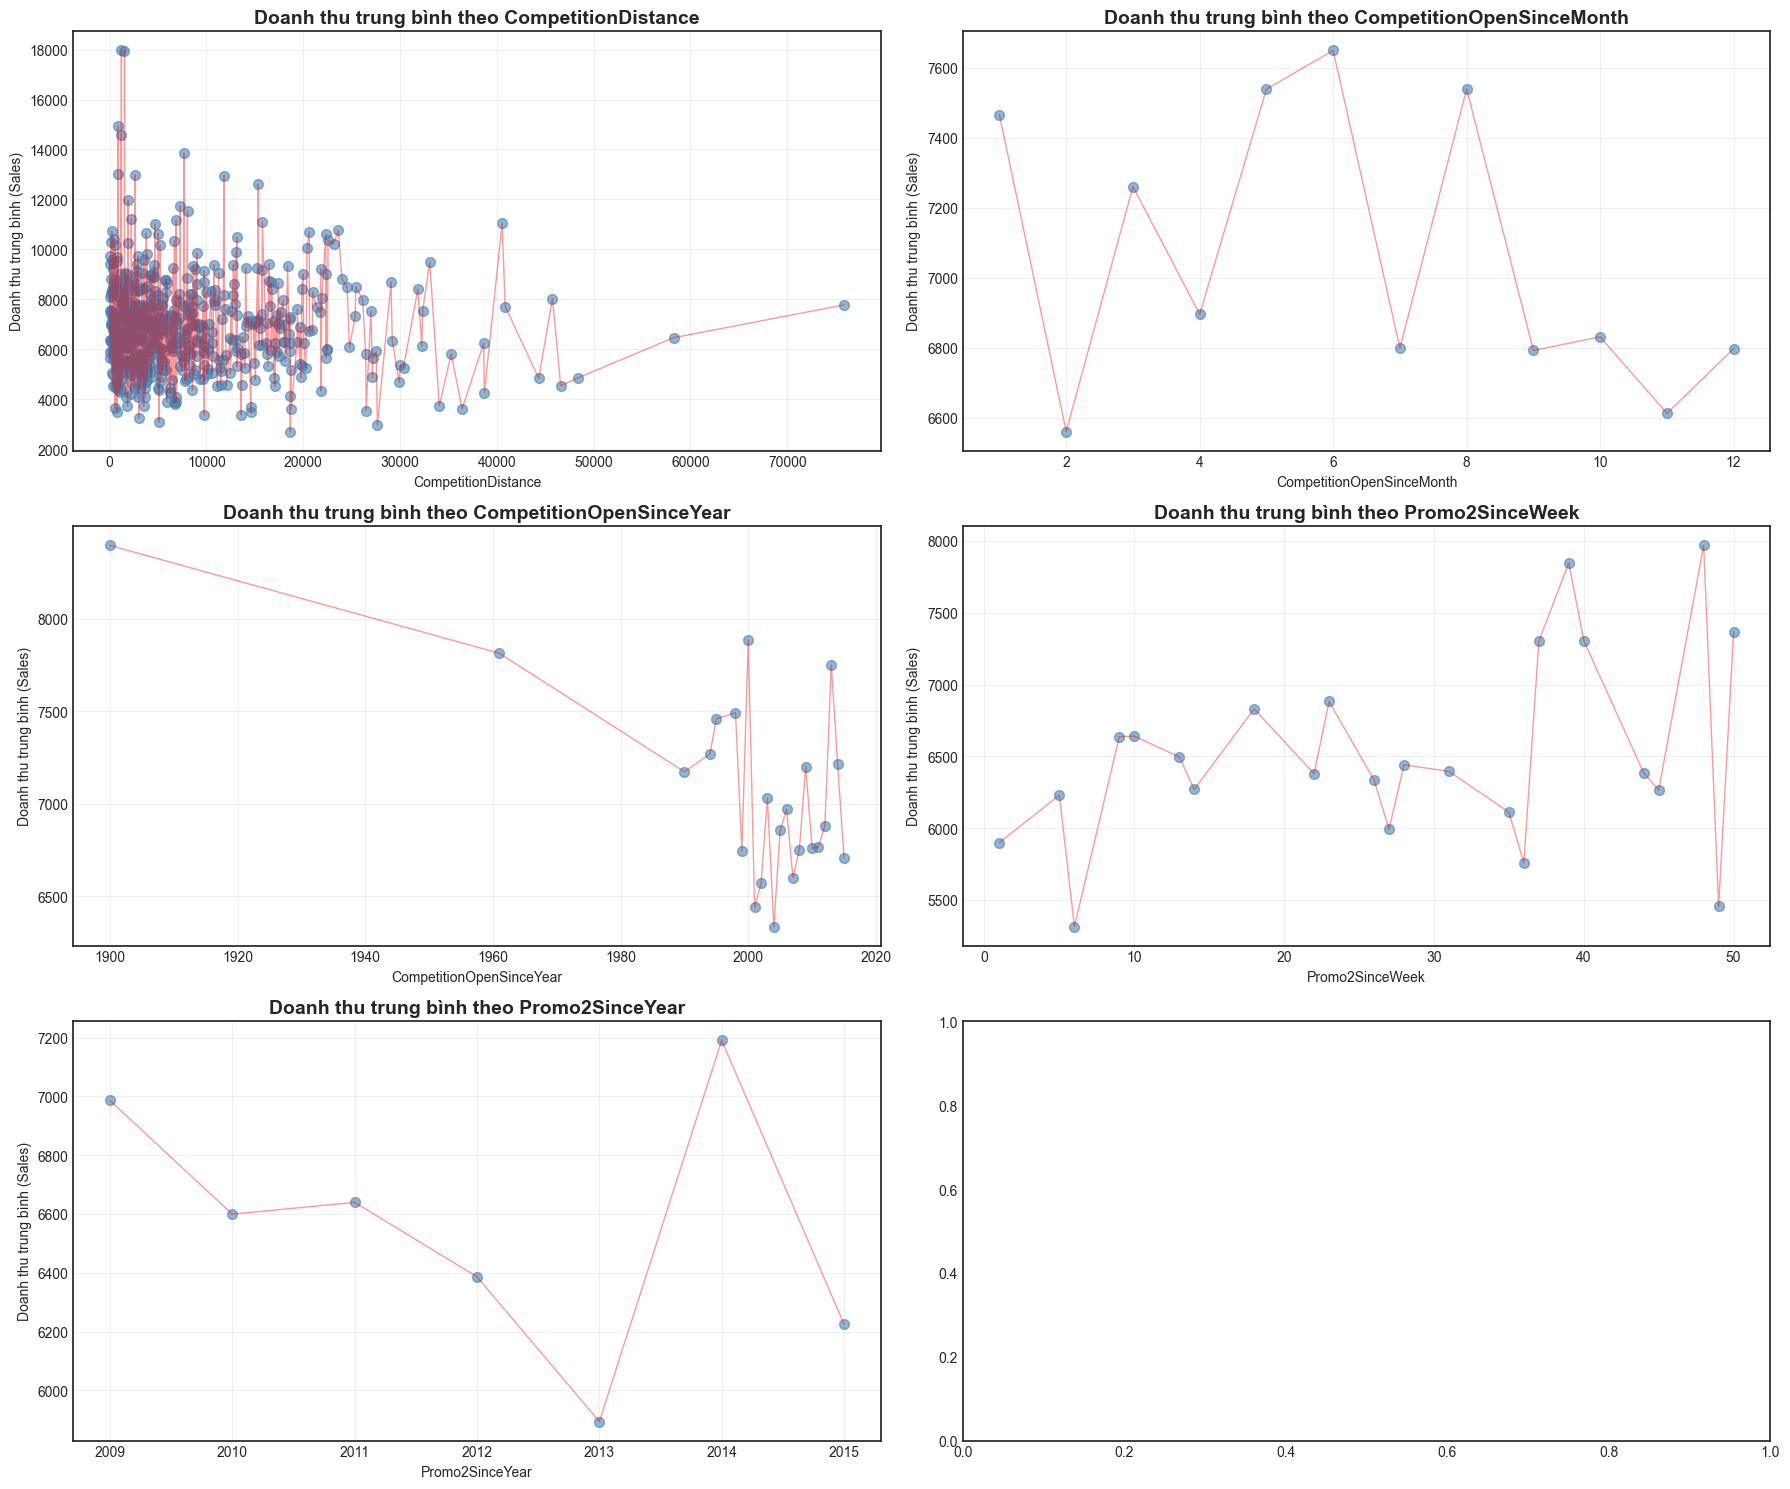

In [311]:
numerical_vars = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                  'Promo2SinceWeek', 'Promo2SinceYear']

fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.ravel()

for idx, var in enumerate(numerical_vars):
    ax = axes[idx]
    df_plot = df_merged[df_merged['Sales'] > 0][[var, 'Sales']].copy()

    if df_plot.empty or df_plot[var].nunique() == 0:
        ax.set_visible(False)
        continue

    # Tính doanh thu trung bình theo từng giá trị của biến
    grouped = df_plot.groupby(var)['Sales'].mean().reset_index()

    # Vẽ scatter plot kết hợp đường nối
    ax.scatter(grouped[var], grouped['Sales'], alpha=0.6, s=50, color='steelblue')
    ax.plot(grouped[var], grouped['Sales'], alpha=0.4, color='red', linewidth=1)

    ax.set_title(f'Doanh thu trung bình theo {var}', fontsize=14, fontweight='bold')
    ax.set_xlabel(var)
    ax.set_ylabel('Doanh thu trung bình (Sales)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Doanh thu trung bình với các biến theo tuần không thấy được xu hướng rõ ràng nào

2. Doanh thu trung bình khi áp dụng `promo2` biến thiên khá linh hoạt, điểm nhấn là doanh thu trung bình vào năm 2013 là thấp nhất nhưng lại cao nhất vào năm 2014, cho thấy chiến lược khuyến mãi dài hạn thực sự tác động lớn đến doanh thu của cửa hàng nhưng cần phân tích sâu hơn để rút ra kết luận chính xác.

C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\2850615427.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sales = df_plot_bar.groupby(var, dropna=False)['Sales'].mean().sort_values(ascending=False)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\2850615427.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sales = df_plot_bar.groupby(var, dropna=False)['Sales'].mean().sort_values(ascending=False)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\2850615427.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

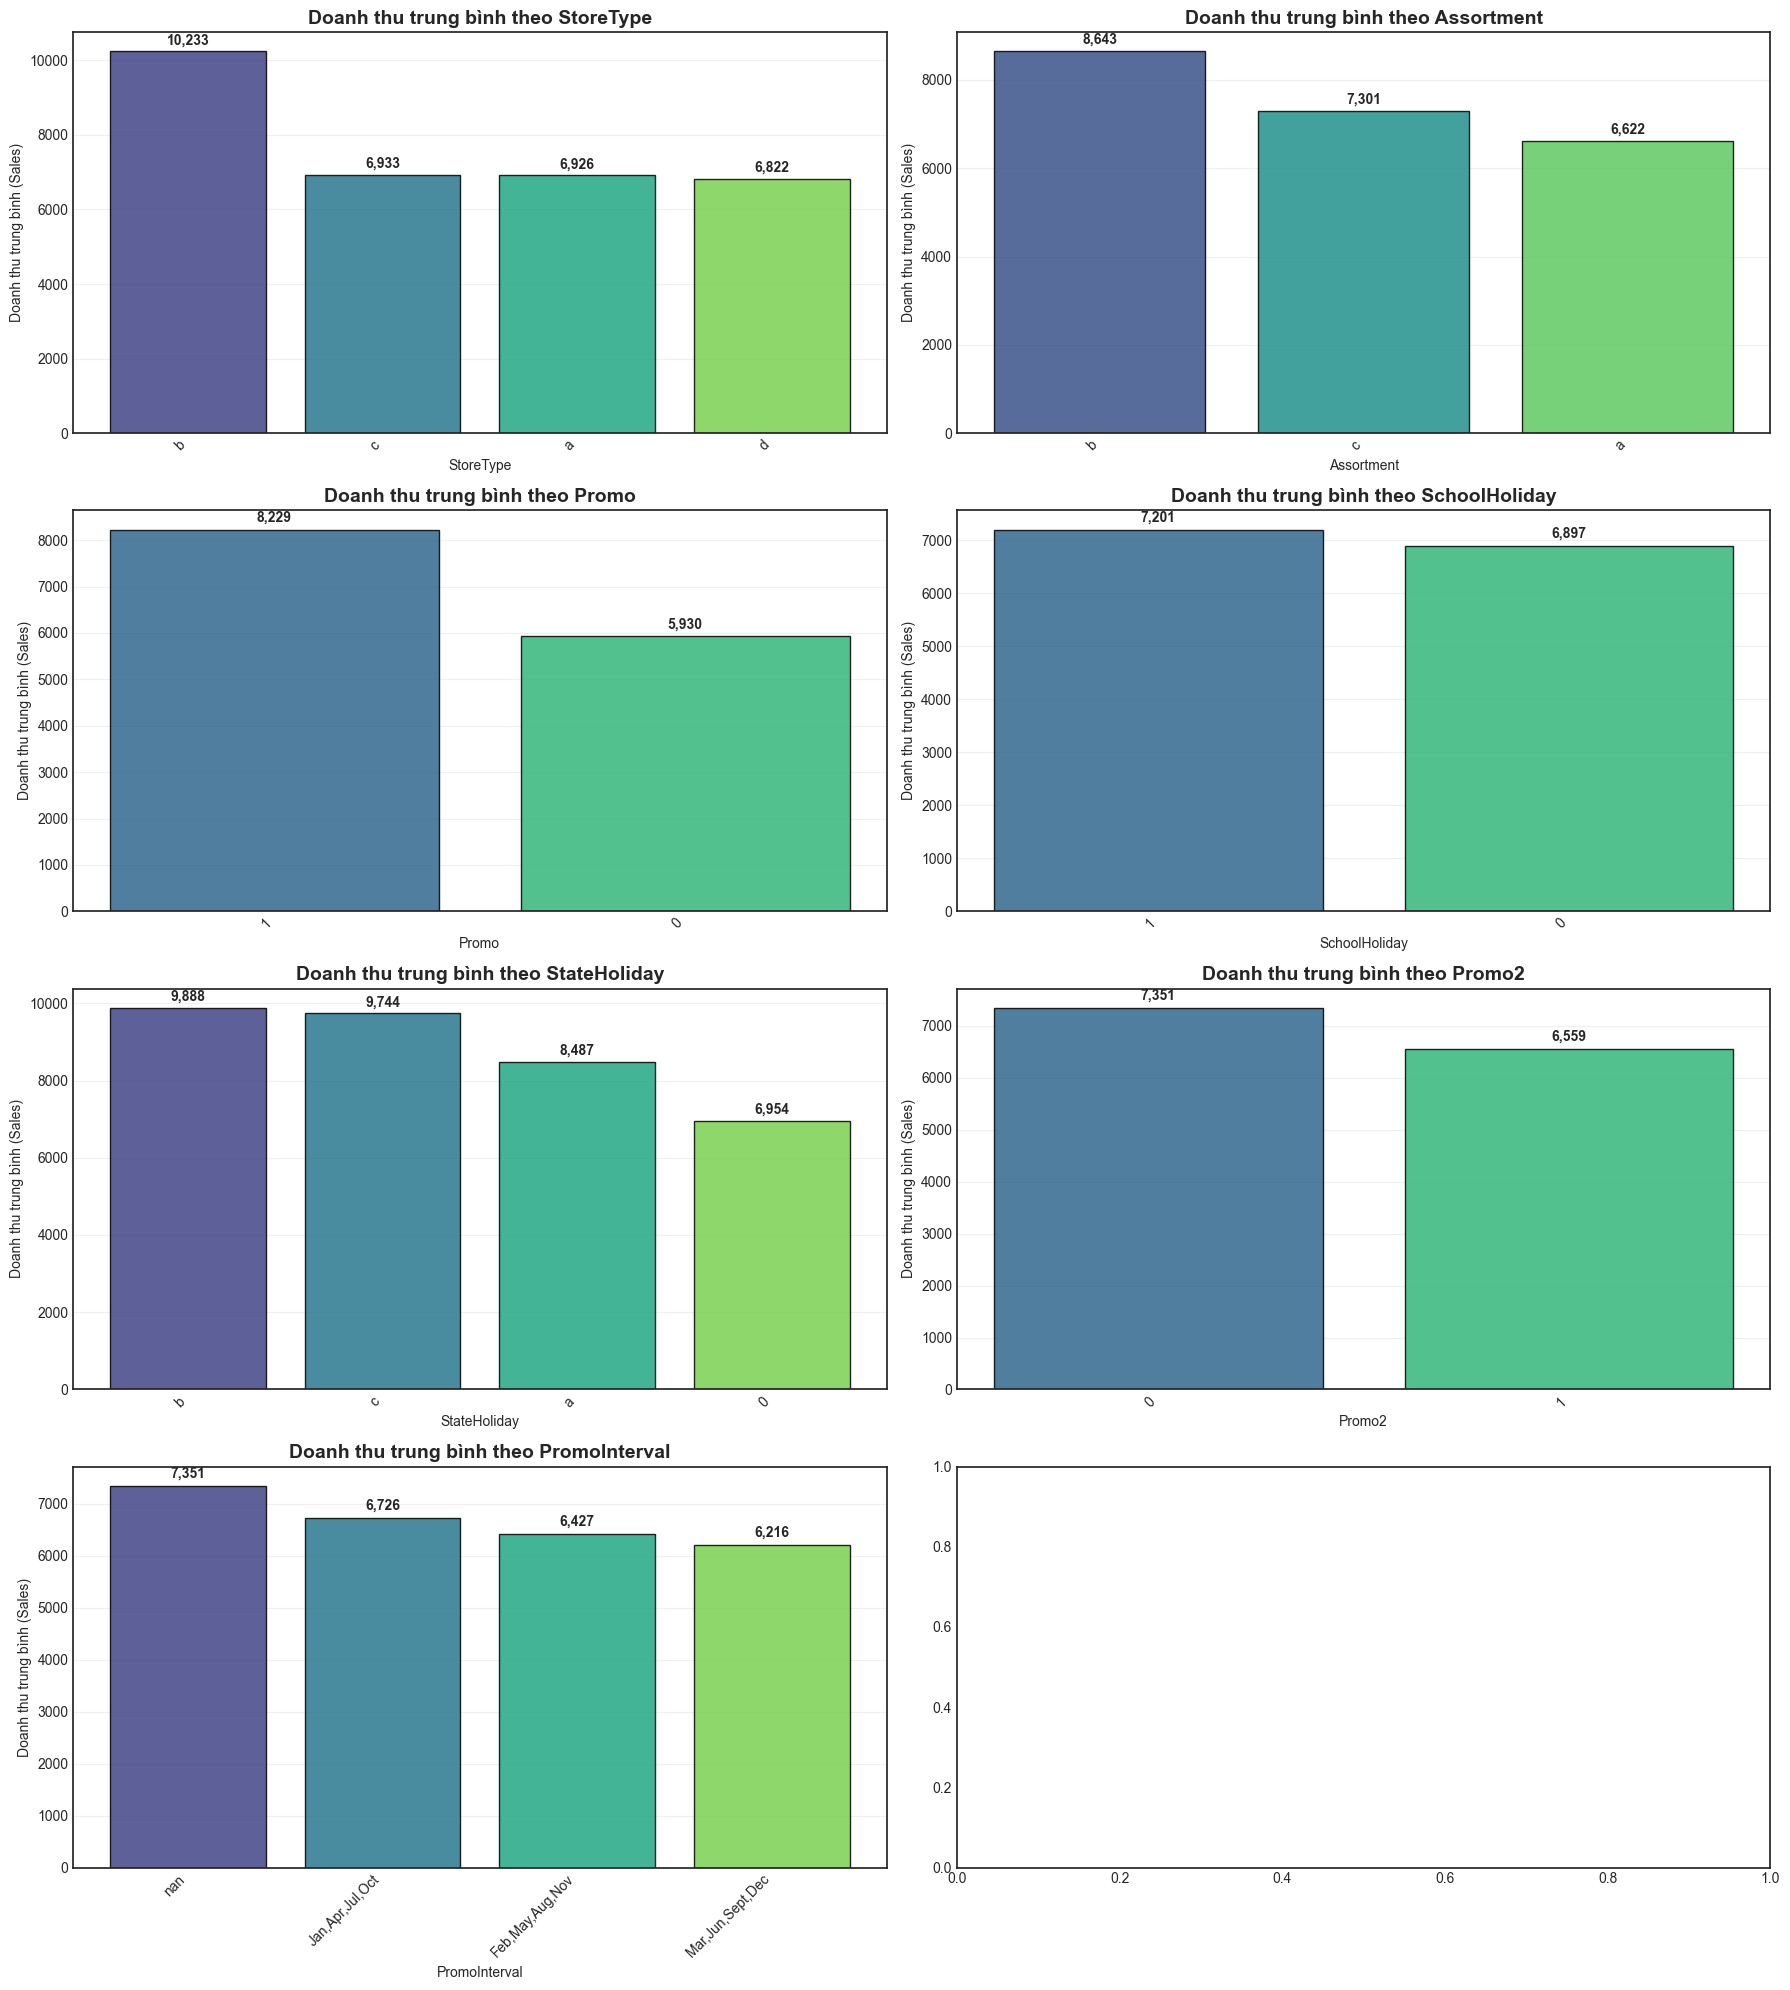

In [312]:
# Vẽ barplot để xem doanh thu trung bình theo các biến categorical, nhị phân và PromoInterval
# Lọc dữ liệu: chỉ lấy những ngày có Sales > 0
df_plot_bar = df_merged[df_merged['Sales'] > 0].copy()

# Danh sách các biến cần phân tích
categorical_binary_vars_bar = ['StoreType', 'Assortment', 'Promo', 'SchoolHoliday', 'StateHoliday', 'Promo2', 'PromoInterval']

# Tạo subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.ravel()

for idx, var in enumerate(categorical_binary_vars_bar):
    ax = axes[idx]

    # Tính doanh thu trung bình theo từng nhóm (giữ cả NaN nếu có)
    avg_sales = df_plot_bar.groupby(var, dropna=False)['Sales'].mean().sort_values(ascending=False)

    # Chuẩn bị bảng màu phân biệt rõ từng nhóm
    colors = sns.color_palette('viridis', len(avg_sales))

    # Vẽ barplot với màu sắc
    ax.bar(range(len(avg_sales)), avg_sales.values, color=colors, edgecolor='black', alpha=0.85)
    ax.set_xticks(range(len(avg_sales)))
    ax.set_xticklabels(avg_sales.index.astype(str), rotation=45, ha='right')

    ax.set_title(f'Doanh thu trung bình theo {var}', fontsize=14, fontweight='bold')
    ax.set_xlabel(var)
    ax.set_ylabel('Doanh thu trung bình (Sales)')
    ax.grid(axis='y', alpha=0.3)

    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(avg_sales.values):
        ax.text(i, v + 100, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [313]:
# Thống kê số lượng cửa hàng mỗi loại, số lượng assortment mỗi loại, và state holiday mỗi loại
store_type_counts = df_store['StoreType'].value_counts()
assortment_counts = df_store['Assortment'].value_counts()
holiday_counts = df_train['StateHoliday'].value_counts()
store_type_counts, assortment_counts, holiday_counts


(StoreType
 a    602
 d    348
 c    148
 b     17
 Name: count, dtype: int64,
 Assortment
 a    593
 c    513
 b      9
 Name: count, dtype: int64,
 StateHoliday
 0    986159
 a     20260
 b      6690
 c      4100
 Name: count, dtype: int64)

1. `StoreType b` có doanh thu trung bình cao nhất so với các loại khác, tuy nhiên loại cửa hàng này chỉ chiếm tỉ lệ rất nhỏ trong tổng số cửa hàng (khoảng 1%) nên cần phân tích thêm để rút ra kết luận chính xác.

2. Cũng tương tự đối với loại `assortment b`, mặc dù có doanh thu trung bình cao nhất nhưng chỉ chiếm tỉ lệ rất nhỏ (khoảng 1%).

3. Trung bình doanh thu và các ngày lễ khá lớn vượt trội so với các ngày không phải lễ hội, nhất là các ngày lễ giáng sinh và lễ phục sinh, tuy nhiên số lượng ngày lễ so với tổng số ngày lại rất nhỏ.

4. Doanh thu khi cửa hàng áp dụng `promo` cao hơn rõ rệt rõ với khi không áp dụng, cho thấy các chương trình khuyến mãi ngắn hạn thực sự có tác động tích cực đến doanh thu của cửa hàng. Tuy nhiên biểu đồ `promo2` cho thấy điều ngược lại, điều này chưa thuyết phục lắm cần phân tích sâu hơn để rút ra kết luận chính xác.

5. Các biến còn lại có doanh thu khá đồng đều giữa các giá trị.

#### Kết luận phân tích 2 biến


<b> 1. Các biến liên quan đến đối thủ </b>
- Các cửa hàng không có thông tin về khoảng cách đối thủ (`CompetitionDistance`) thì cũng đồng thời thiếu thông tin năm và tháng đối thủ mở cửa là hợp lý. Tuy nhiên, khi chỉ thiếu `CompetitionOpenSinceMonth/Year` mà `CompetitionDistance` vẫn có → điều này phản ánh dữ liệu cạnh tranh bị thiếu một phần do không thu thập được thời điểm mở cửa của đối thủ

- Các cửa hàng nằm gần đối thủ lại có doanh thu cao hơn.

<b> 2. Các biến liên quan đến promotion </b>
- Khi `Promo2 = 0`, toàn bộ các biến `Promo2SinceWeek` và `Promo2SinceYear` đều bị missing

- `Promo` (khuyến mãi ngắn hạn) làm tăng doanh thu rất rõ rệt.

- `Promo2` chưa xác định rõ được ảnh hưởng khi có lúc mang lại hiệu quả cao có lúc mang lại hiệu quả thấp.

<b> 3. Insight về doanh thu và khách hàng theo yếu tố thời gian, mùa vụ </b>
- Doanh thu và lượng khách hàng thể hiện mối quan hệ tương đồng rất rõ ràng, điều này hoàn toàn hợp lý vì khách hàng là yếu tố quyết định trực tiếp doanh thu.

- Năm 2015 có doanh thu trung bình tăng nhưng lượng khách trung bình giảm do ít khách hơn nhưng giá trị đơn hàng trung bình cao hơn.

- Doanh thu giảm mạnh vào chủ nhật và tháng 1 và tháng 5.

- Doanh thu tăng cao vào đầu tuần Các tháng cuối năm.

- Có 52 ngày cửa hàng mở cửa nhưng không có khách, và 2 ngày có khách nhưng không bán được sản phẩm nào.

- Doanh thu trung bình ở các ngày lễ lớn hơn so với doanh thu trung bình của các ngày bình thường, đặc biệt là vào lễ phục sinh và giấng sinh.

<b> 4. Doanh thu theo các loại cửa hàng </b>
- `StoreType b` và `Assortment b` có doanh thu cao nhất nhưng cả hai nhóm này chỉ chiếm ~1% dữ liệu.

### <b>Phân tích đa biến</b>

#### Xem xét mối quan hệ của doanh thu theo thời gian theo `StoreType`


C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\4034746860.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_merged, x='DayOfWeek', y='Sales', hue='StoreType', ax=axes[0], marker='o', ci=None, linewidth=3, palette=custom_palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\4034746860.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_merged, x='Month', y='Sales', hue='StoreType', ax=axes[1], marker='o', ci=None, linewidth=3, palette=custom_palette)
C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\4034746860.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_offset, x='Year', y='Sales', hue='StoreType', ax=axes[2], marker='o', ci=None, linewidth=3, palette=custom_palette)


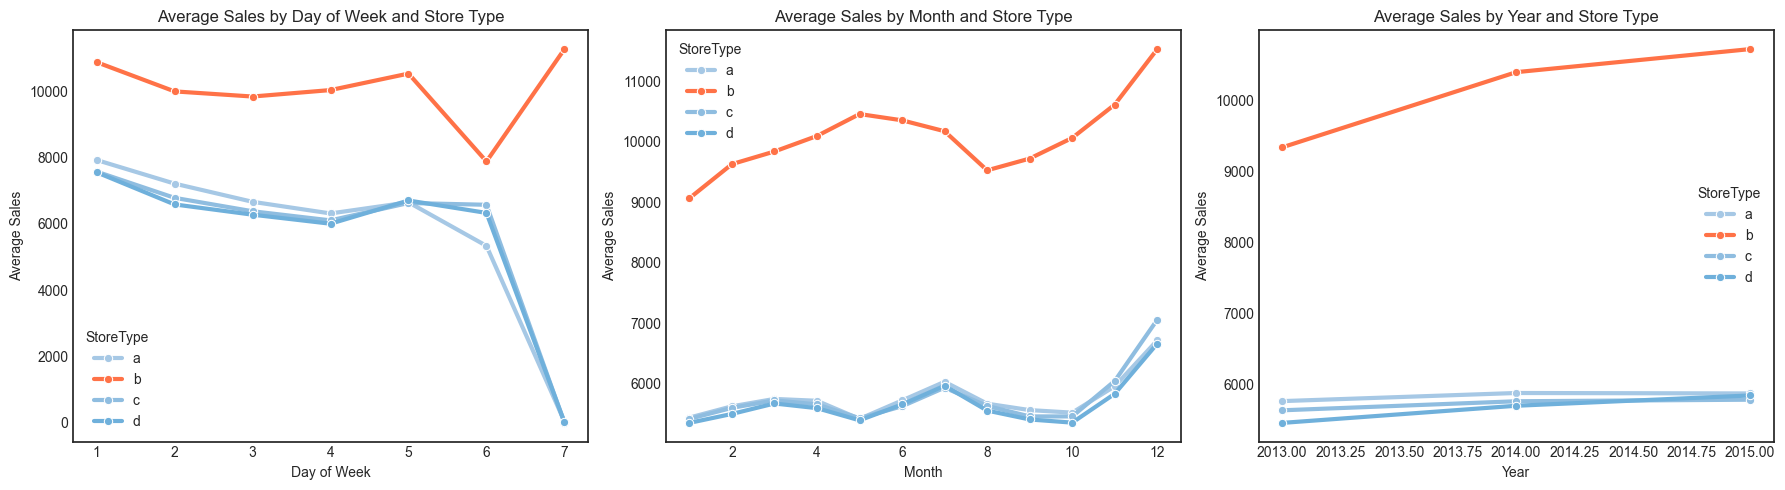

In [314]:
# Vẽ 3 lineplot cho từng StoreType để xem doanh thu theo ngày trong tuần, tháng, năm
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# custom_palette = {
#     'a': '#1f77b4',   # xanh dương muted
#     'c': '#2ca02c',   # xanh lá muted
#     'd': '#17becf',   # xanh teal đậm
#     'b': '#ff7f0e'    # cam sáng -> nổi nhất
# }
custom_palette = {
    'a': '#A6C8E5',
    'b': "#FF7247",
    'c': '#8FBDE0',
    'd': '#6FB0DB'
}


# Lineplot theo DayOfWeek
sns.lineplot(data=df_merged, x='DayOfWeek', y='Sales', hue='StoreType', ax=axes[0], marker='o', ci=None, linewidth=3, palette=custom_palette)
axes[0].set_title('Average Sales by Day of Week and Store Type')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Sales')

# Lineplot theo Month
sns.lineplot(data=df_merged, x='Month', y='Sales', hue='StoreType', ax=axes[1], marker='o', ci=None, linewidth=3, palette=custom_palette)
axes[1].set_title('Average Sales by Month and Store Type')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Sales')

# Lineplot theo Year
df_offset = df_merged.copy()
df_offset.loc[df_offset['StoreType']=='a', 'Sales'] += 100  # Dịch lên 10 để tránh chồng lấn
sns.lineplot(data=df_offset, x='Year', y='Sales', hue='StoreType', ax=axes[2], marker='o', ci=None, linewidth=3, palette=custom_palette)
axes[2].set_title('Average Sales by Year and Store Type')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average Sales')

plt.tight_layout()
plt.show()

1. Các cửa hàng thường tăng doanh thu rất mạnh vào cuối năm khoảng tháng 11 và 12, đối với các ngày trong tuần các `StoreType a,c,d` đều sụt giảm doanh thu trầm trọng vào ngày chủ nhật còn `StoreType b` lại tăng doanh thu vào ngày chủ nhật nhưng lại sụt giảm sâu vào ngày thứ 7

2. `StoreType b` có doanh thu trung bình luôn luôn cao nhất theo thời gian, tuy nhiên dữ liệu về các loại cửa hàng bị mất cân đối nghiêm trọng khi số cửa hàng `StoreType b` chỉ chiếm khoảng 1% tổng số cửa hàng.

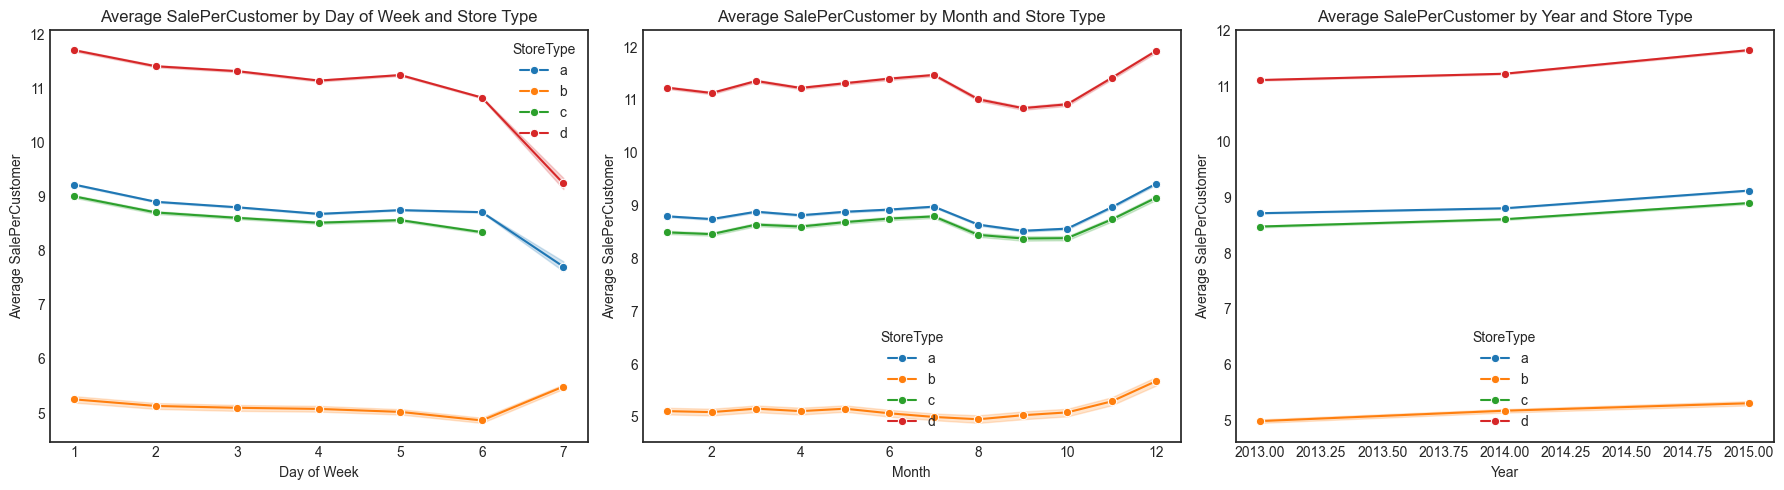

In [315]:
# Vẽ 3 lineplot cho từng StoreType để xem doanh thu theo ngày trong tuần, tháng, năm
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Lineplot theo DayOfWeek
sns.lineplot(data=df_offset.reset_index(), x='DayOfWeek', y='SalePerCustomer', hue='StoreType', ax=axes[0], marker='o')
axes[0].set_title('Average SalePerCustomer by Day of Week and Store Type')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average SalePerCustomer')

# Lineplot theo Month
sns.lineplot(data=df_offset.reset_index(), x='Month', y='SalePerCustomer', hue='StoreType', ax=axes[1], marker='o')
axes[1].set_title('Average SalePerCustomer by Month and Store Type')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average SalePerCustomer')  

# Lineplot theo Year
sns.lineplot(data=df_offset.reset_index(), x='Year', y='SalePerCustomer', hue='StoreType', ax=axes[2], marker='o')
axes[2].set_title('Average SalePerCustomer by Year and Store Type')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average SalePerCustomer')

plt.tight_layout()
plt.show()

_Xét theo doanh thu trên từng khách hàng thì `StoreType b` lại thấp nhất mặc dù ở trên rất cao, cửa hàng `StoreType d` cao nhất. Có lẽ do số lượng khách hàng của các loại cửa hàng??_


In [316]:
# Lọc dữ liệu: chỉ lấy những ngày mở cửa và có doanh thu > 0
df_open = df_merged[(df_merged['Open'] == 1) & (df_merged['Sales'] > 0)].copy()

# Tính cột SalePerCustomer (Doanh thu trên mỗi khách)
df_open['SalePerCustomer'] = df_open['Sales'] / df_open['Customers']

# Gom nhóm theo StoreType và tính toán các chỉ số
stats = (
    df_open.groupby('StoreType', observed=False).agg({
        'Store': 'nunique',
        'Sales': 'mean',
        'Customers': 'mean',
        'SalePerCustomer': 'mean'
    })
    .round(2)
    .rename(columns={
        'Store': 'Số lượng Store',
        'Sales': 'Doanh thu TB/ngày',
        'Customers': 'Số khách TB/ngày',
        'SalePerCustomer': 'Giá trị đơn TB/khách'
    })
)
stats

Số lượng Store  Doanh thu TB/ngày  Số khách TB/ngày  \
StoreType                                                        
a                     602            6925.70            795.42   
b                      17           10233.38           2022.21   
c                     148            6933.13            815.54   
d                     348            6822.30            606.35   

           Giá trị đơn TB/khách  
StoreType                        
a                          8.85  
b                          5.13  
c                          8.63  
d                         11.28

1. Thật sự vậy, cửa hàng `StoreType b` đúng là có số lượng khách trung bình ngày doanh thu trung bình ngày nhiều nhất nhưng số lượng store lại ít nhất nên tổng doanh thu sẽ ít nhất nhưng performance rất tốt, đây là loại cửa hàng hiếm vì số lượng store ít và khách hàng vào mua đông nhưng mua với giá trị ít

2. Cửa hàng `StoreType d` ngược lại có doanh thu và số khách trung bình ngày ít nhất nhưng sale per customer lại vượt trội nhất, đây là loại cửa hàng có lẽ là bán hàng hóa có giá trị cao nhất nên mới ít khách và sale per customer cao

3. Cửa hàng `StoreType a` và `StoreType c` khá giống nhau có lẽ đều bán các loại hàng tiêu dùng phổ biến

#### Xem xét mối quan hệ giữa doanh thu và biến `promotion` theo thời gian và theo loại cửa hàng


C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\2198644152.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = sales_positive.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack().reindex(index=store_types)


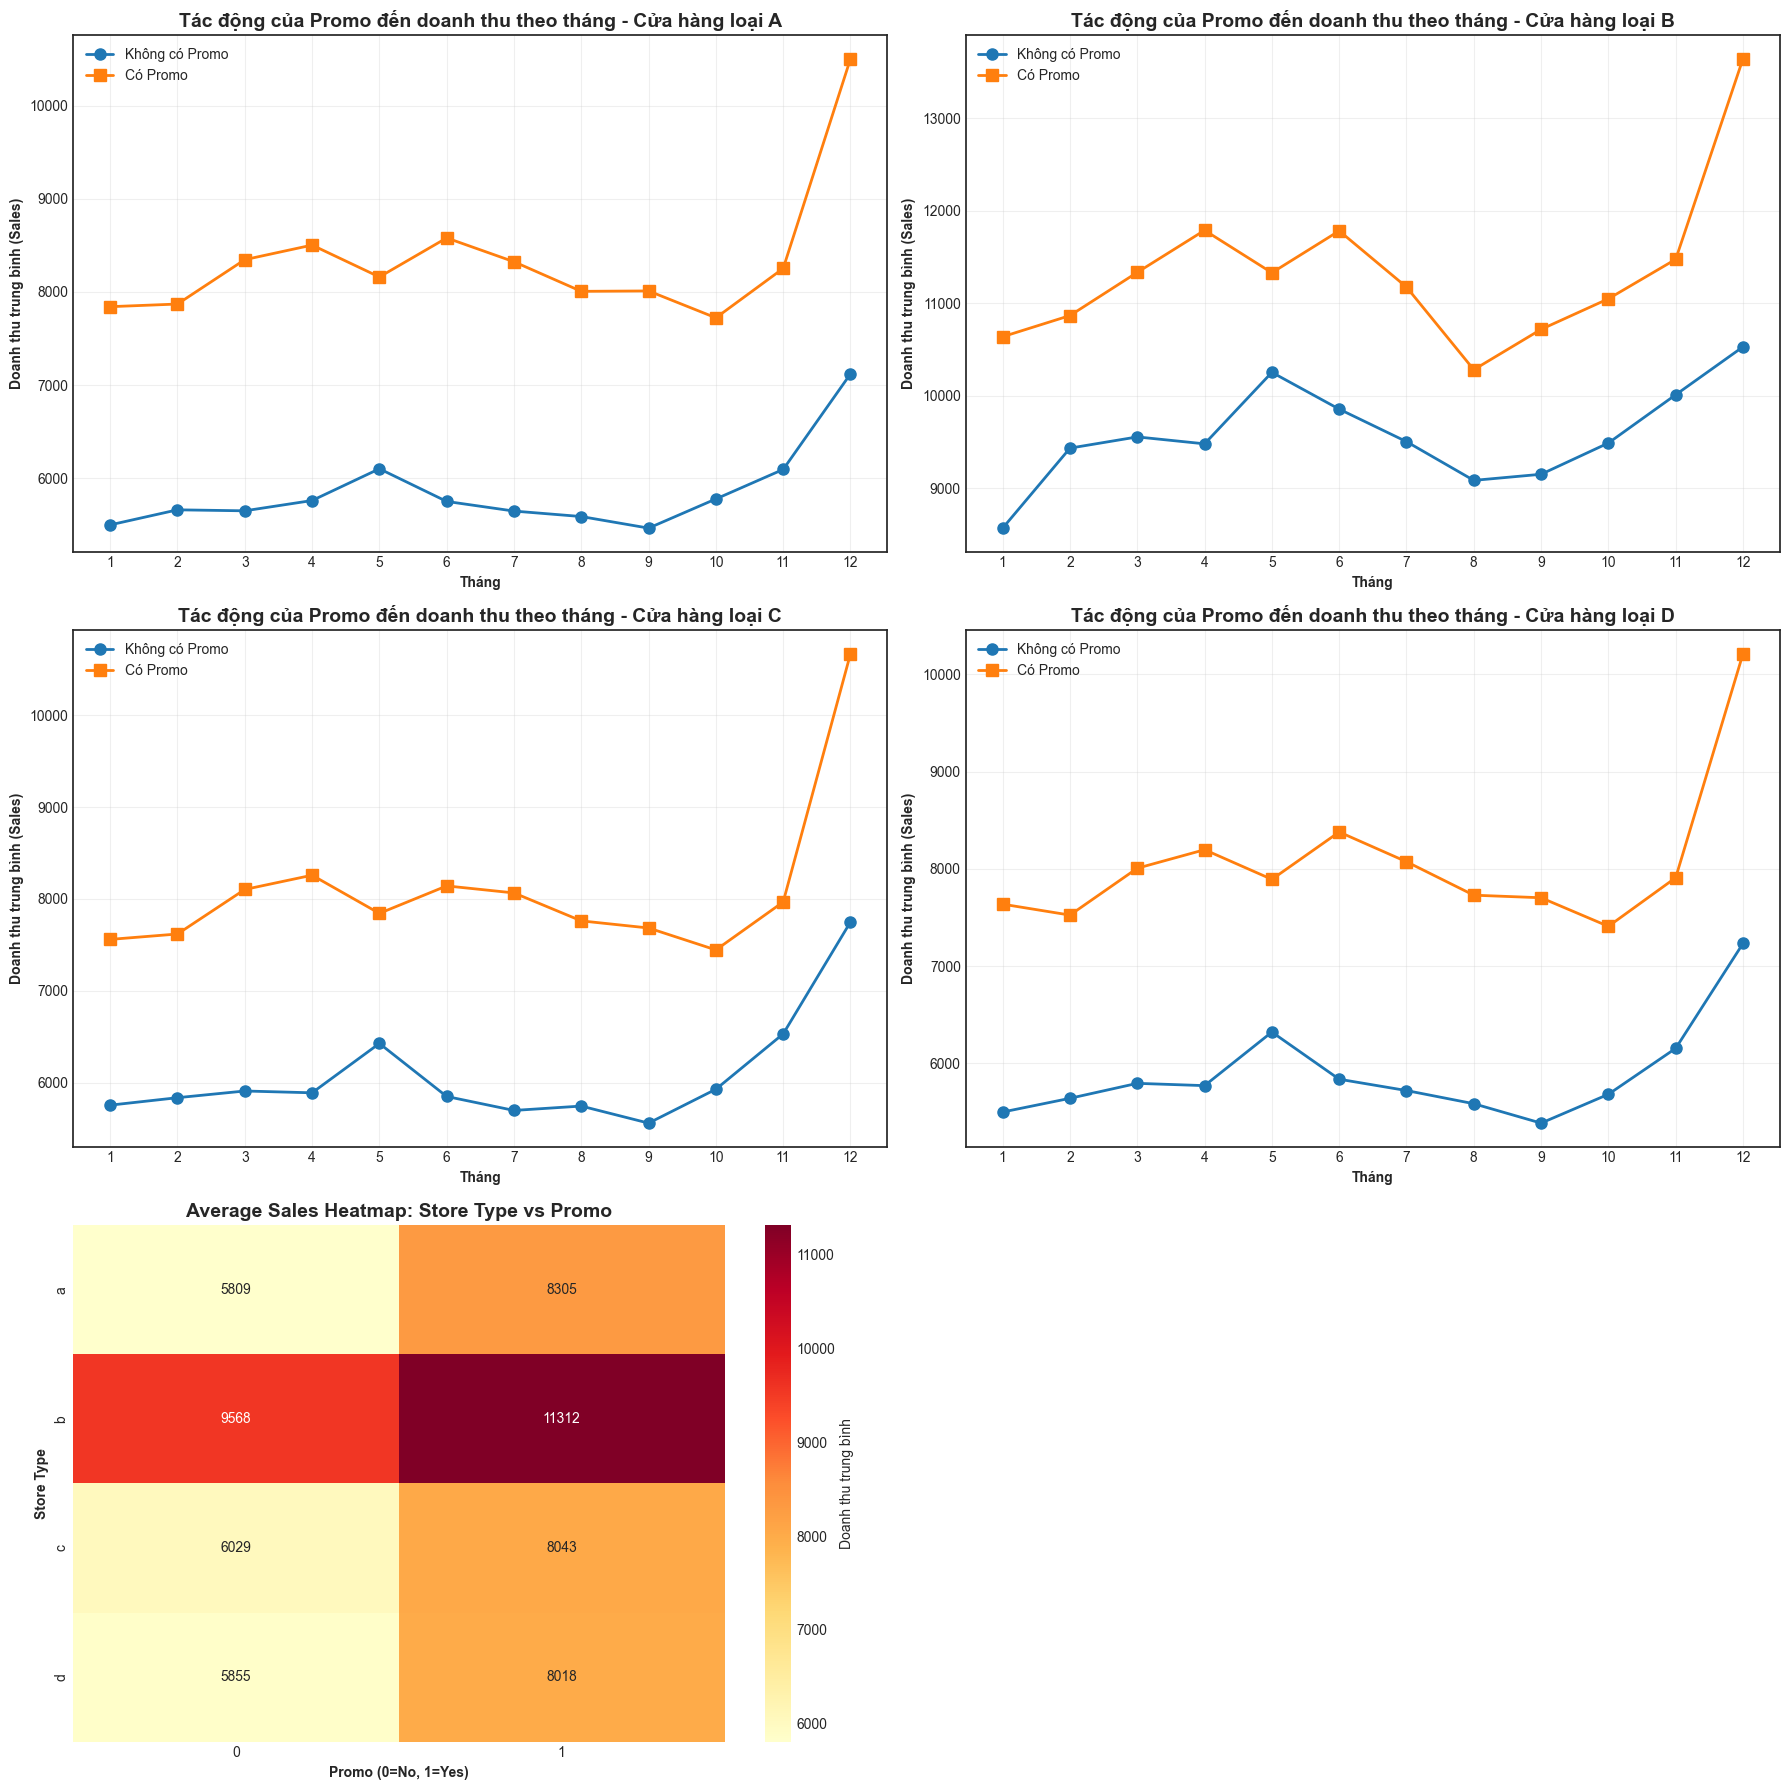

In [317]:
# Vẽ 4 biểu đồ đường thể hiện tác động của Promo đến doanh thu theo tháng cho từng loại cửa hàng
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.ravel()

store_types = ['a', 'b', 'c', 'd']
sales_positive = df_merged[df_merged['Sales'] > 0]

for idx, store_type in enumerate(store_types):
    ax = axes[idx]
    # Lọc dữ liệu theo loại cửa hàng và có doanh thu > 0
    df_store_type = sales_positive[sales_positive['StoreType'] == store_type]
    
    if df_store_type.empty:
        ax.set_visible(False)
        continue
    
    # Tính doanh thu trung bình theo tháng và Promo
    monthly_sales_no_promo = df_store_type[df_store_type['Promo'] == 0].groupby('Month')['Sales'].mean()
    monthly_sales_with_promo = df_store_type[df_store_type['Promo'] == 1].groupby('Month')['Sales'].mean()
    
    # Vẽ biểu đồ
    ax.plot(monthly_sales_no_promo.index, monthly_sales_no_promo.values, 
            marker='o', linewidth=2, markersize=8, label='Không có Promo', color='#1f77b4')
    ax.plot(monthly_sales_with_promo.index, monthly_sales_with_promo.values, 
            marker='s', linewidth=2, markersize=8, label='Có Promo', color='#ff7f0e')
    
    ax.set_title(f'Tác động của Promo đến doanh thu theo tháng - Cửa hàng loại {store_type.upper()}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Tháng', fontweight='bold')
    ax.set_ylabel('Doanh thu trung bình (Sales)', fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(1, 13))

# Biểu đồ heatmap thể hiện doanh thu trung bình theo StoreType và Promo
heatmap_ax = axes[4]
heatmap_data = sales_positive.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack().reindex(index=store_types)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Doanh thu trung bình'}, ax=heatmap_ax)
heatmap_ax.set_title('Average Sales Heatmap: Store Type vs Promo', fontsize=14, fontweight='bold')
heatmap_ax.set_xlabel('Promo (0=No, 1=Yes)', fontweight='bold')
heatmap_ax.set_ylabel('Store Type', fontweight='bold')

# Ẩn subplot còn lại nếu không dùng
axes[5].axis('off')

plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\2781169600.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = sales_positive.groupby(['StoreType', 'Promo2'])['Sales'].mean().unstack().reindex(index=store_types)


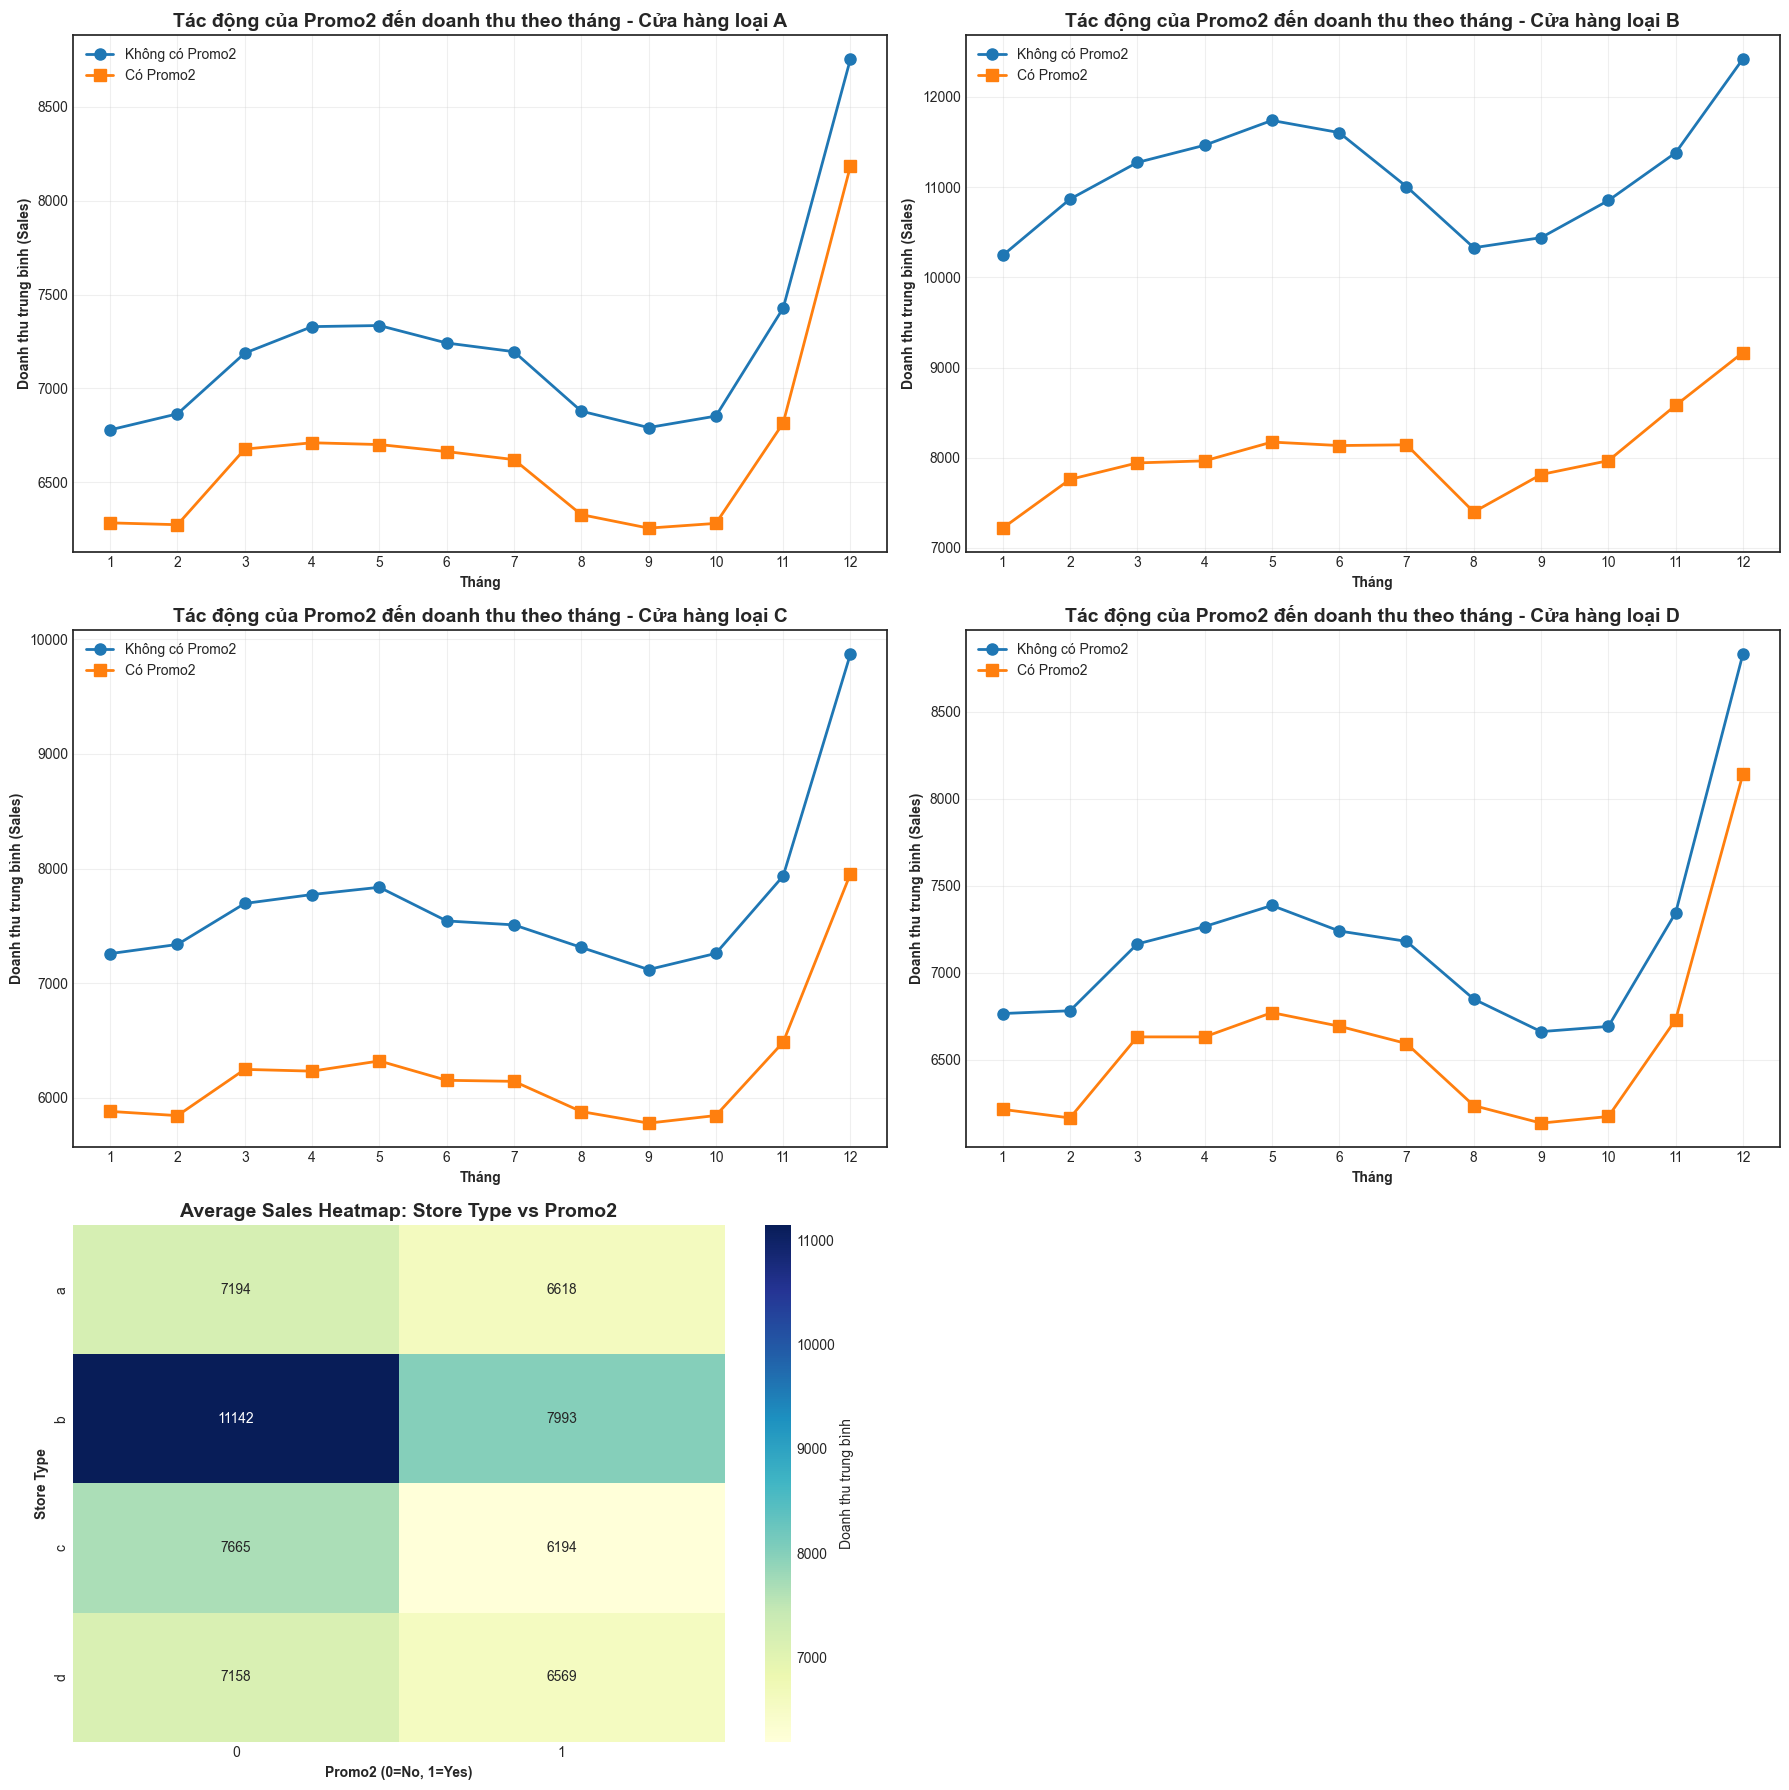

In [318]:
# Vẽ 4 biểu đồ đường thể hiện tác động của Promo2 đến doanh thu theo tháng cho từng loại cửa hàng
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.ravel()

store_types = ['a', 'b', 'c', 'd']
sales_positive = df_merged[df_merged['Sales'] > 0]

for idx, store_type in enumerate(store_types):
    ax = axes[idx]
    # Lọc dữ liệu theo loại cửa hàng và có doanh thu > 0
    df_store_type = sales_positive[sales_positive['StoreType'] == store_type]
    
    if df_store_type.empty:
        ax.set_visible(False)
        continue
    
    # Tính doanh thu trung bình theo tháng và Promo2
    monthly_sales_no_promo2 = df_store_type[df_store_type['Promo2'] == 0].groupby('Month')['Sales'].mean()
    monthly_sales_with_promo2 = df_store_type[df_store_type['Promo2'] == 1].groupby('Month')['Sales'].mean()
    
    # Vẽ biểu đồ
    ax.plot(monthly_sales_no_promo2.index, monthly_sales_no_promo2.values, 
            marker='o', linewidth=2, markersize=8, label='Không có Promo2', color='#1f77b4')
    ax.plot(monthly_sales_with_promo2.index, monthly_sales_with_promo2.values, 
            marker='s', linewidth=2, markersize=8, label='Có Promo2', color='#ff7f0e')
    
    ax.set_title(f'Tác động của Promo2 đến doanh thu theo tháng - Cửa hàng loại {store_type.upper()}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Tháng', fontweight='bold')
    ax.set_ylabel('Doanh thu trung bình (Sales)', fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(1, 13))

# Biểu đồ heatmap thể hiện doanh thu trung bình theo StoreType và Promo2
heatmap_ax = axes[4]
heatmap_data = sales_positive.groupby(['StoreType', 'Promo2'])['Sales'].mean().unstack().reindex(index=store_types)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Doanh thu trung bình'}, ax=heatmap_ax)
heatmap_ax.set_title('Average Sales Heatmap: Store Type vs Promo2', fontsize=14, fontweight='bold')
heatmap_ax.set_xlabel('Promo2 (0=No, 1=Yes)', fontweight='bold')
heatmap_ax.set_ylabel('Store Type', fontweight='bold')

# Ẩn subplot còn lại nếu không dùng
axes[5].axis('off')

plt.tight_layout()
plt.show()

1. Loại cửa hàng `StoreType b` luôn có doanh thu cao nhất khi áp dụng cả 2 loại promotion `promo` và `promo2`

2. Xu hướng biến động doanh thu ở cả 2 biểu đồ của 2 biến `promo` và `promo2` tương đối giống nhau, tuy nhiên ở biểu đồ `promo` thì việc áp dụng mang lại doanh thu cao hơn rõ rệt so với không áp dụng, trong khi ở biểu đồ `promo2` thì doanh thu khi áp dụng `promo2` lại thấp hơn so với không áp dụng. Điều này cho thấy các biến promotion thật sự cần được phân tích sâu hơn để hiểu được nguyên nhân đằng sau.

#### Xem xét mối quan hệ giữa doanh thu và biến `competition distance` theo thời gian và theo loại cửa hàng


C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\465108623.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_type['CompDistanceBin'] = pd.cut(df_store_type['CompetitionDistance'],
C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\465108623.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_type['CompDistanceBin'] = pd.cut(df_store_type['CompetitionDistance'],
C:\Users\ACER\AppData\Local\Temp\ipykernel_14040\465108623.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy

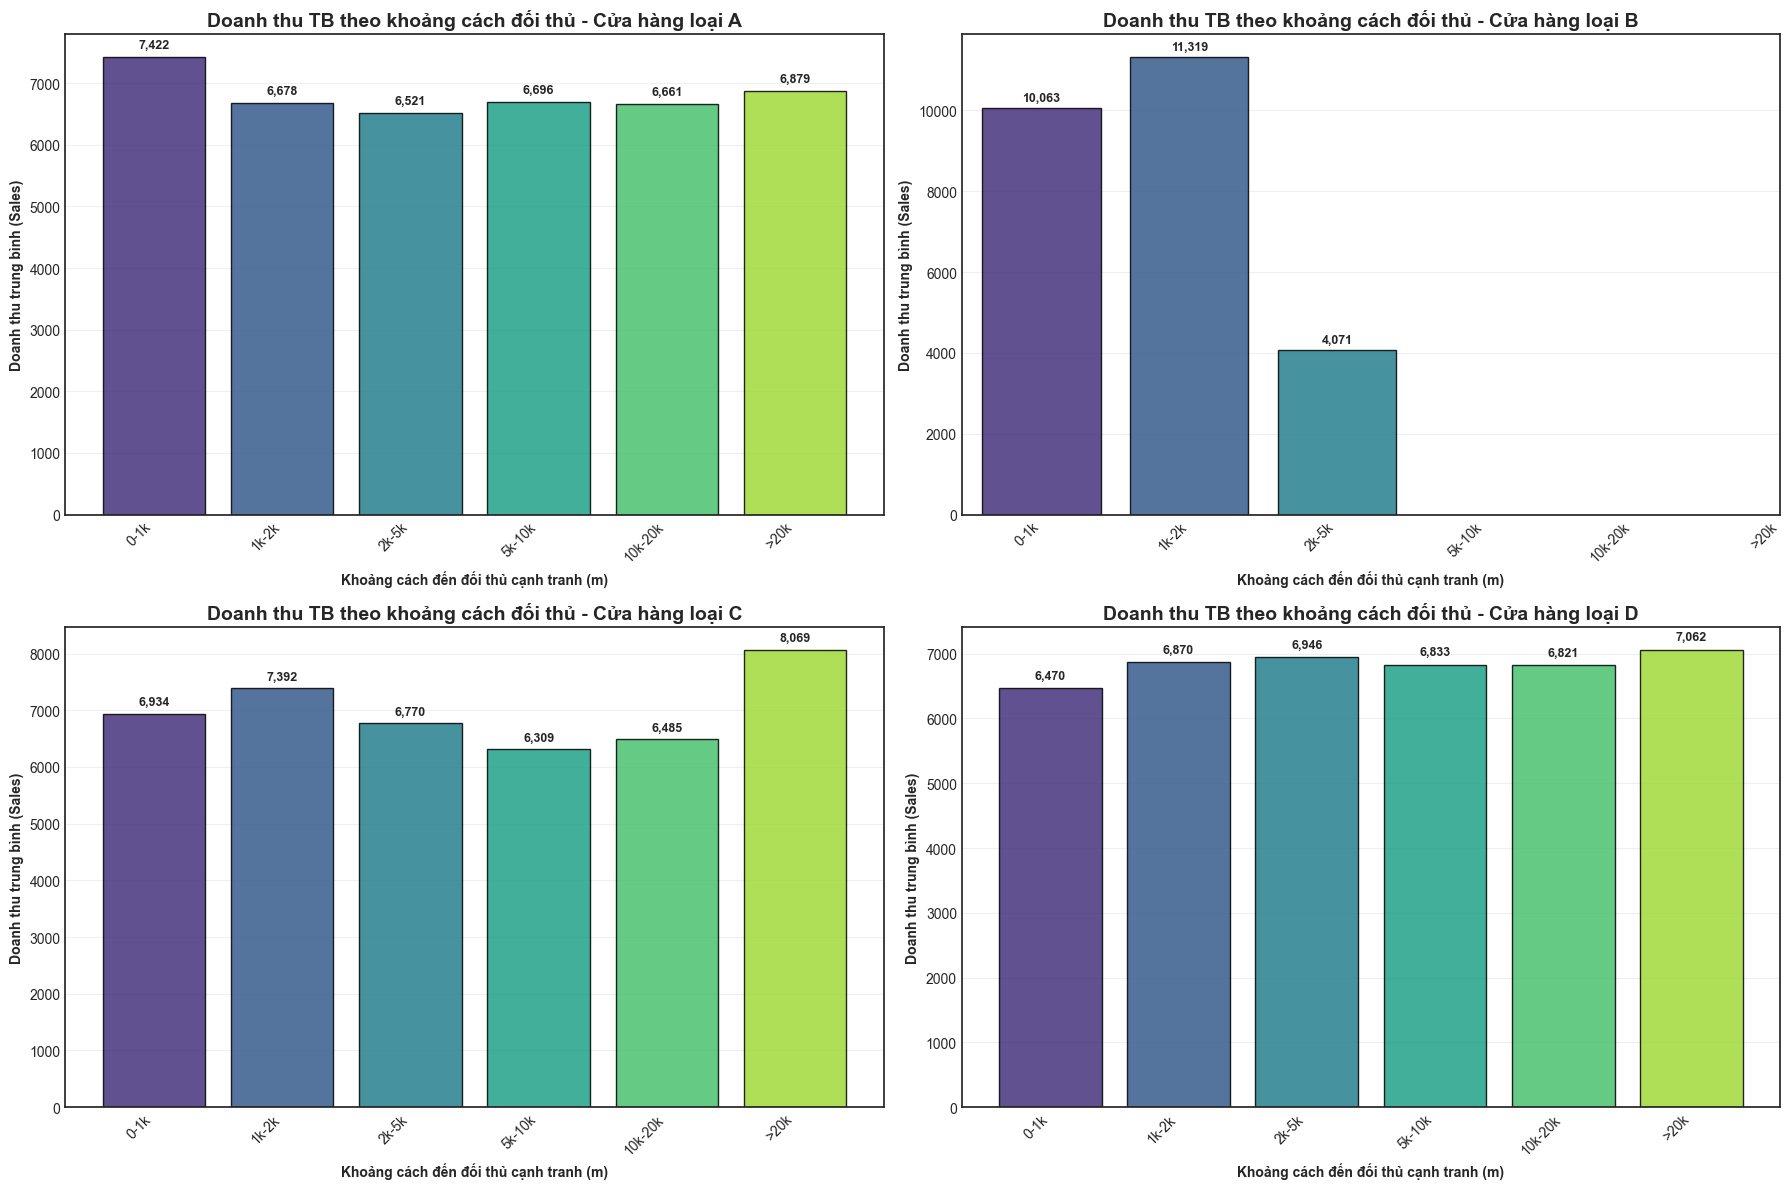

In [319]:
# Vẽ 4 biểu đồ scatter plot thể hiện mối quan hệ giữa doanh thu và CompetitionDistance cho từng loại cửa hàng
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

store_types = ['a', 'b', 'c', 'd']

for idx, store_type in enumerate(store_types):
    # Lọc dữ liệu theo loại cửa hàng và có doanh thu > 0
    df_store_type = df_merged[(df_merged['StoreType'] == store_type) & (df_merged['Sales'] > 0)]
    
    # Tính doanh thu trung bình theo khoảng cách cạnh tranh (nhóm theo bins để dễ quan sát)
    # Chia CompetitionDistance thành các bins
    df_store_type['CompDistanceBin'] = pd.cut(df_store_type['CompetitionDistance'], 
                                                bins=[0, 1000, 2000, 5000, 10000, 20000, 80000], 
                                                labels=['0-1k', '1k-2k', '2k-5k', '5k-10k', '10k-20k', '>20k'])
    
    # Tính doanh thu trung bình theo bin
    avg_sales_by_distance = df_store_type.groupby('CompDistanceBin', observed=False)['Sales'].mean()
    
    # Vẽ bar plot
    colors = sns.color_palette('viridis', len(avg_sales_by_distance))
    axes[idx].bar(range(len(avg_sales_by_distance)), avg_sales_by_distance.values, 
                  color=colors, edgecolor='black', alpha=0.85)
    axes[idx].set_xticks(range(len(avg_sales_by_distance)))
    axes[idx].set_xticklabels(avg_sales_by_distance.index, rotation=45, ha='right')
    
    axes[idx].set_title(f'Doanh thu TB theo khoảng cách đối thủ - Cửa hàng loại {store_type.upper()}', 
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Khoảng cách đến đối thủ cạnh tranh (m)', fontweight='bold')
    axes[idx].set_ylabel('Doanh thu trung bình (Sales)', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(avg_sales_by_distance.values):
        axes[idx].text(i, v + 100, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

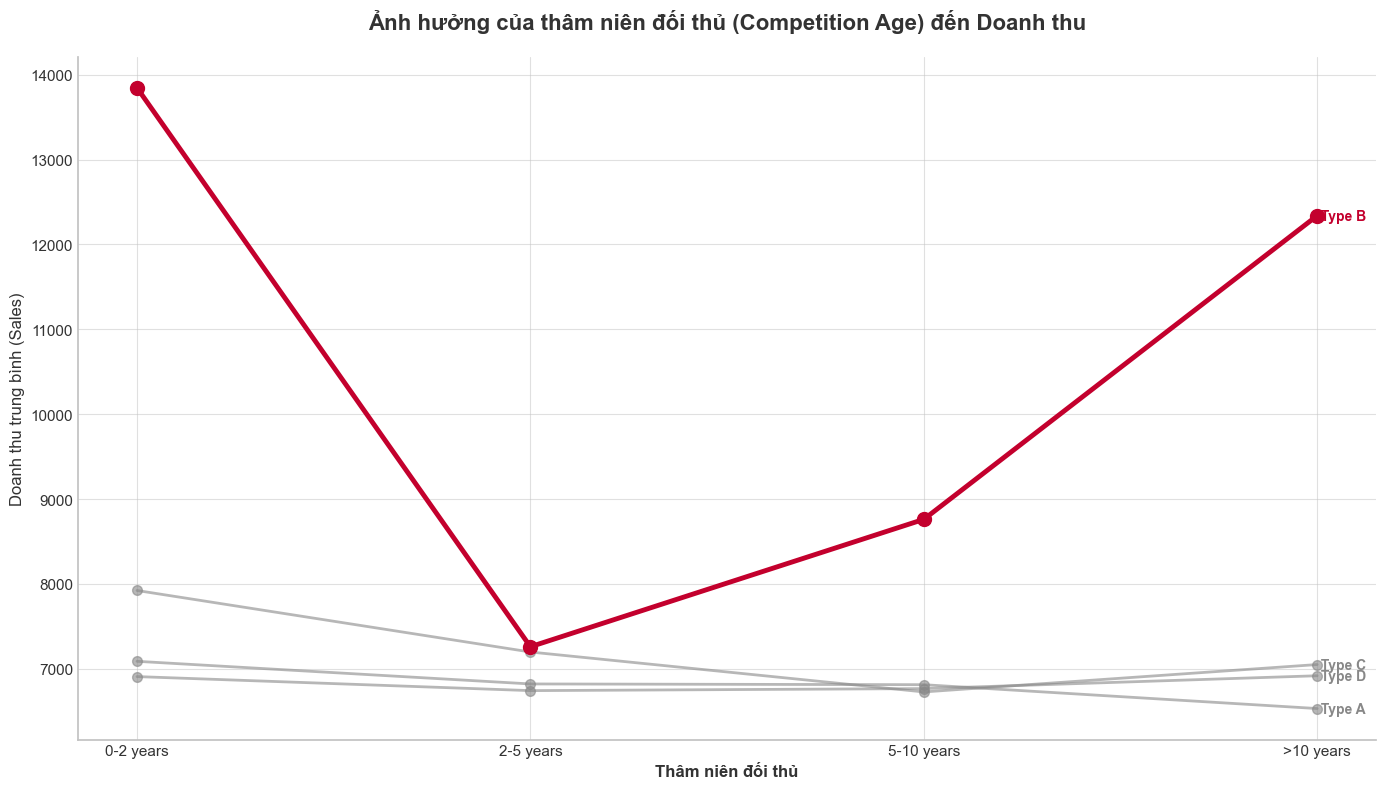

In [320]:
ROSSMANN_RED = '#C3002D'
GREY_NEUTRAL = '#888888'
GREY_LIGHT   = '#C3C3C3'
TEXT_COLOR   = '#333333'
BG_COLOR     = '#FFFFFF'
df_comp = df_merged[df_merged['Sales'] > 0].copy()
df_comp['CompetitionAge'] = df_comp['Year'] - df_comp['CompetitionOpenSinceYear']
df_comp.loc[df_comp['CompetitionAge'] < 0, 'CompetitionAge'] = -1
df_comp['CompetitionAge'] = df_comp['CompetitionAge'].fillna(-1)
# Tạo bins
# Lưu ý: include_lowest=True để không bỏ sót biên
df_comp['CompAgeGroup'] = pd.cut(df_comp['CompetitionAge'], 
                                 bins=[0, 2, 5, 10, 100], 
                                 labels=['0-2 years', '2-5 years', '5-10 years', '>10 years'],
                                 include_lowest=True)

# Tính toán
avg_sales_by_comp_age = df_comp.groupby(['StoreType', 'CompAgeGroup'], observed=False)['Sales'].mean().reset_index()
# --- VẼ BIỂU ĐỒ ---
fig, ax = plt.subplots(figsize=(14, 8), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)
store_types = ['a', 'b', 'c', 'd']

# Tìm ra StoreType có doanh thu trung bình cao nhất để Highlight 
best_store_type = avg_sales_by_comp_age.groupby('StoreType', observed=False)['Sales'].mean().idxmax()
for store_type in store_types:
    data = avg_sales_by_comp_age[avg_sales_by_comp_age['StoreType'] == store_type]
    # Bỏ qua nếu không có dữ liệu sau khi binning
    if data['Sales'].isna().all():
        continue
    # Logic Highlight
    if store_type == best_store_type:
        color = ROSSMANN_RED
        linewidth = 3.5
        alpha = 1.0
        zorder = 10 # Đưa lên trên cùng
        label = f'Store Type {store_type.upper()} (Cao nhất)'
        marker_size = 10
    else:
        color = GREY_NEUTRAL
        linewidth = 2
        alpha = 0.6 # Làm mờ bớt
        zorder = 1
        label = f'Store Type {store_type.upper()}'
        marker_size = 7
    # Vẽ line
    ax.plot(data['CompAgeGroup'], data['Sales'], 
            marker='o', linewidth=linewidth, markersize=marker_size,
            color=color, alpha=alpha, label=label, zorder=zorder)
# Label trực tiếp tại điểm cuối cùng (Thay thế hoặc bổ trợ cho Legend)
# Lấy điểm cuối cùng hợp lệ
    last_point = data.dropna().iloc[-1]
    ax.text(last_point['CompAgeGroup'], last_point['Sales'], 
            f" Type {store_type.upper()} ", 
            color=color, va='center', fontweight='bold', fontsize=10)
# Formatting
ax.set_title('Ảnh hưởng của thâm niên đối thủ (Competition Age) đến Doanh thu', 
             fontsize=16, fontweight='bold', color=TEXT_COLOR, pad=20)
ax.set_xlabel('Thâm niên đối thủ', fontsize=12, color=TEXT_COLOR, fontweight='bold')
ax.set_ylabel('Doanh thu trung bình (Sales)', fontsize=12, color=TEXT_COLOR)
# Grid và Spines
ax.grid(True, color=GREY_LIGHT, alpha=0.5, linestyle='-', zorder=0)
ax.tick_params(colors=TEXT_COLOR, labelsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(GREY_LIGHT)
ax.spines['bottom'].set_color(GREY_LIGHT)

plt.tight_layout()
plt.show()

1. Ảnh hưởng của khoảng cách cửa hàng đối thủ đến doanh thu của các loại cửa hàng theo thời gian khá đồng đều, chưa rút ra được nhiều kết luận tuy nhiên việc các cửa hàng có đối thủ ở gần có doanh thu cao hơn so với đối thủ ở xa đã phân tích ở bước phân tích 2 biến cần được làm rõ hơn
2. Thâm niên đối thủ thể hiện ảnh hưởng rõ rệt nhất đến cửa hàng loại b, cần khám phá sâu hơn câu chuyện đằng sau 

#### Ảnh hưởng của `StateHoliday` và `SchoolHoliday` với doanh thu theo từng loại cửa hàng


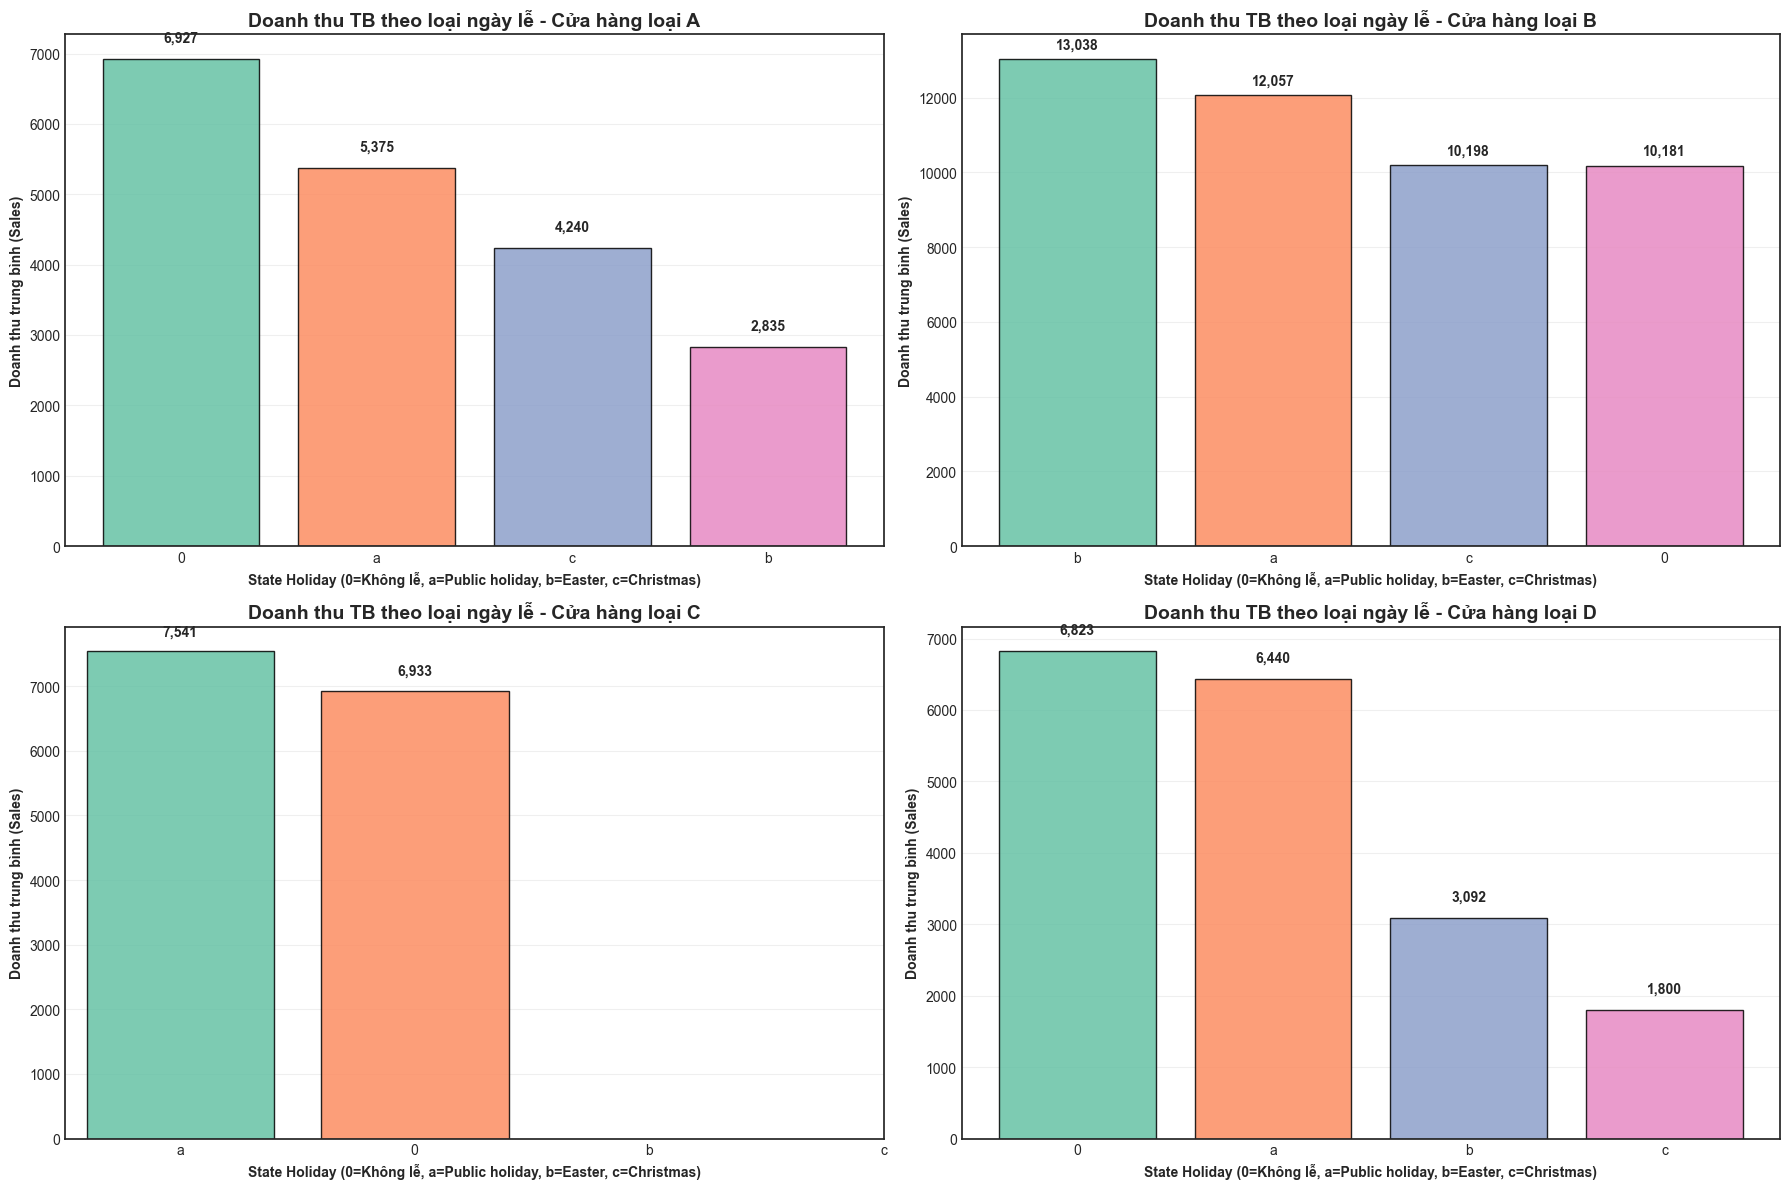

In [321]:
# Vẽ biểu đồ thể hiện ảnh hưởng của StateHoliday đến doanh thu theo từng loại cửa hàng
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

store_types = ['a', 'b', 'c', 'd']

for idx, store_type in enumerate(store_types):
    ax = axes[idx]
    # Lọc dữ liệu theo loại cửa hàng và có doanh thu > 0
    df_store_type = sales_positive[sales_positive['StoreType'] == store_type]
    
    if df_store_type.empty:
        ax.set_visible(False)
        continue
    
    # Tính doanh thu trung bình theo StateHoliday
    avg_sales_by_holiday = df_store_type.groupby('StateHoliday', observed=False)['Sales'].mean().sort_values(ascending=False)
    
    # Tạo màu sắc cho từng loại ngày lễ
    colors = sns.color_palette('Set2', len(avg_sales_by_holiday))
    
    # Vẽ barplot
    ax.bar(range(len(avg_sales_by_holiday)), avg_sales_by_holiday.values, 
           color=colors, edgecolor='black', alpha=0.85)
    ax.set_xticks(range(len(avg_sales_by_holiday)))
    ax.set_xticklabels(avg_sales_by_holiday.index, rotation=0)
    
    ax.set_title(f'Doanh thu TB theo loại ngày lễ - Cửa hàng loại {store_type.upper()}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('State Holiday (0=Không lễ, a=Public holiday, b=Easter, c=Christmas)', fontweight='bold')
    ax.set_ylabel('Doanh thu trung bình (Sales)', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(avg_sales_by_holiday.values):
        ax.text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [322]:
print(f'Số ngày cửa hàng c mở cửa vào dịp giáng sinh: {df_merged[(df_merged["Open"] > 0) & (df_merged["StateHoliday"]=="c") & (df_merged["StoreType"]=="c")].shape[0]}')
print(f'Số ngày cửa hàng c mở cửa vào dịp lễ phục sinh: {df_merged[(df_merged["Open"] > 0) & (df_merged["StateHoliday"]=="b") & (df_merged["StoreType"]=="c")].shape[0]}')


Số ngày cửa hàng c mở cửa vào dịp giáng sinh: 0
Số ngày cửa hàng c mở cửa vào dịp lễ phục sinh: 0


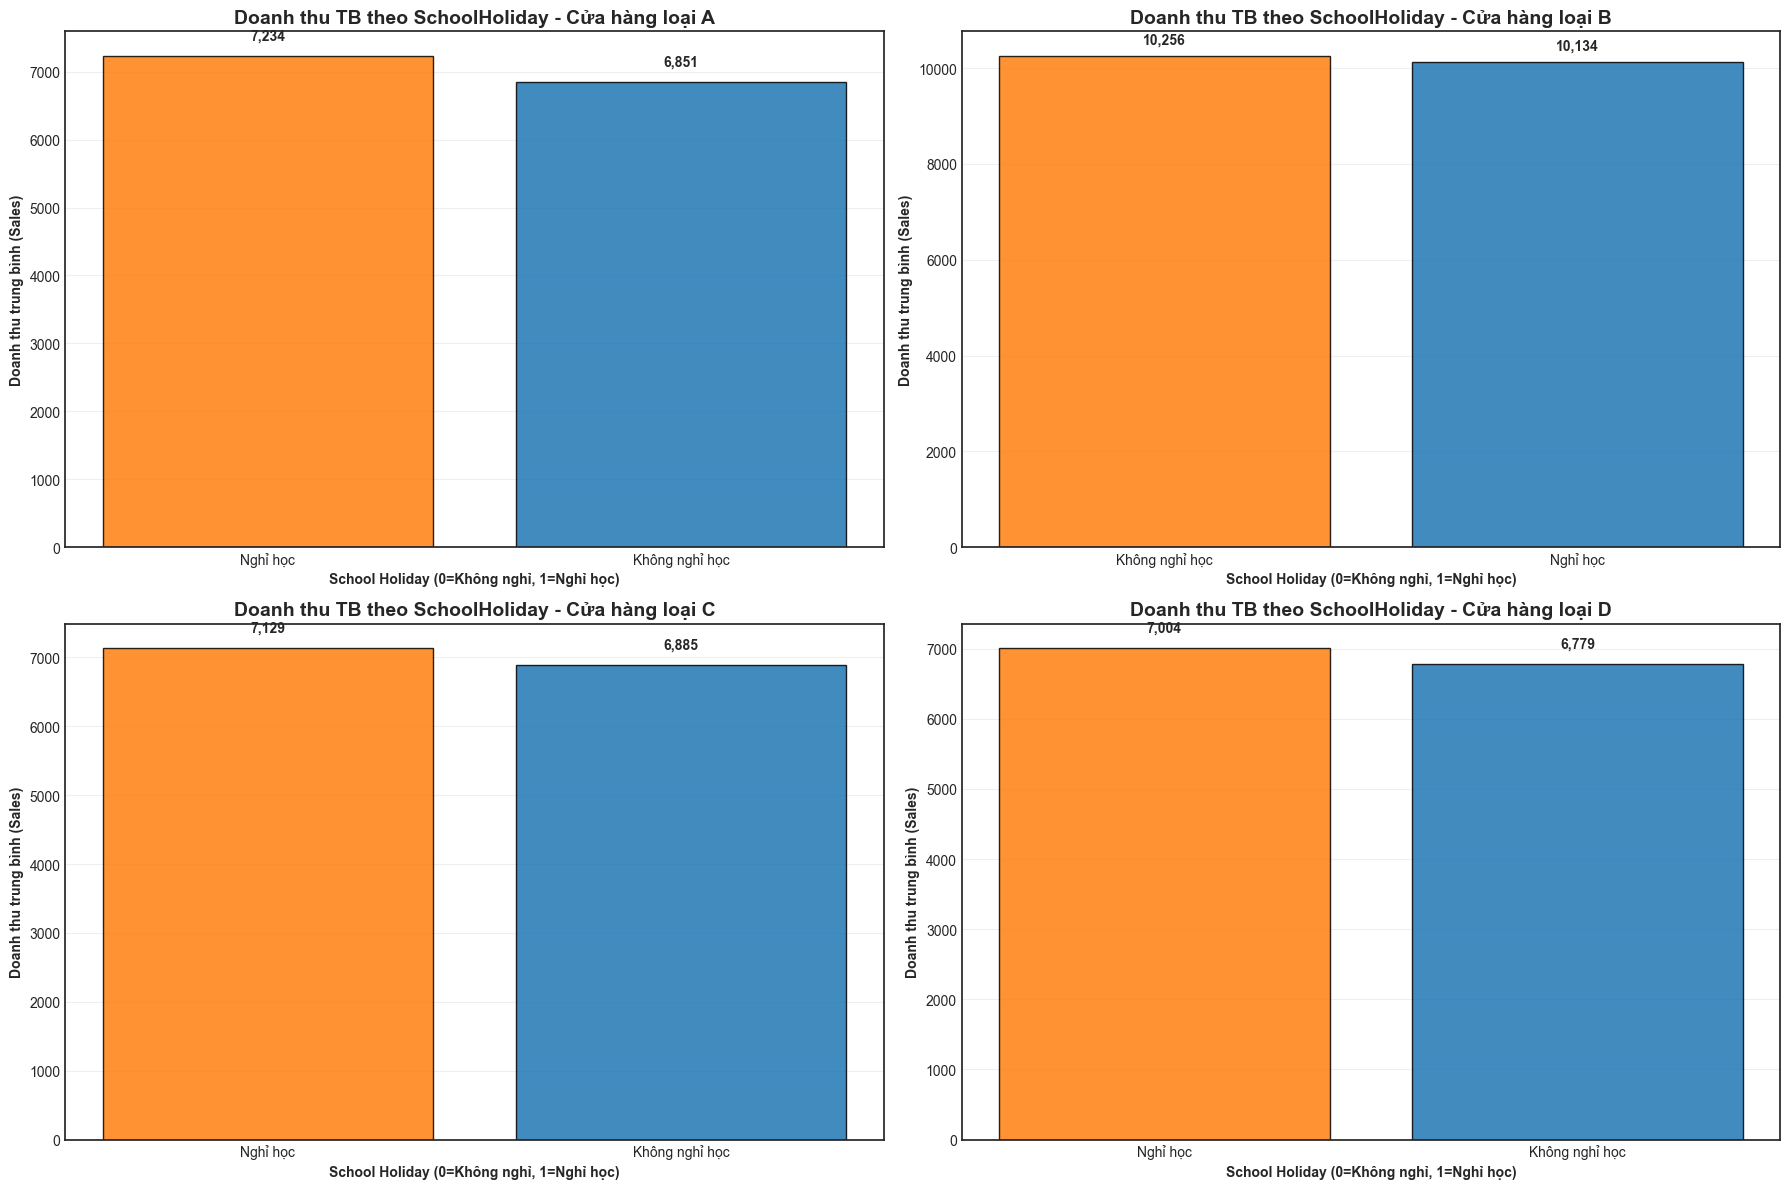

In [323]:
# Vẽ biểu đồ thể hiện ảnh hưởng của SchoolHoliday đến doanh thu theo từng loại cửa hàng
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

store_types = ['a', 'b', 'c', 'd']

for idx, store_type in enumerate(store_types):
    ax = axes[idx]
    # Lọc dữ liệu theo loại cửa hàng và có doanh thu > 0
    df_store_type = sales_positive[sales_positive['StoreType'] == store_type]
    
    if df_store_type.empty:
        ax.set_visible(False)
        continue
    
    # Tính doanh thu trung bình theo SchoolHoliday
    avg_sales_by_school = df_store_type.groupby('SchoolHoliday')['Sales'].mean().sort_values(ascending=False)
    
    # Tạo màu sắc cho từng loại
    colors = ['#ff7f0e', '#1f77b4']
    
    # Vẽ barplot
    ax.bar(range(len(avg_sales_by_school)), avg_sales_by_school.values, 
           color=colors, edgecolor='black', alpha=0.85)
    ax.set_xticks(range(len(avg_sales_by_school)))
    ax.set_xticklabels(['Nghỉ học' if x == 1 else 'Không nghỉ học' for x in avg_sales_by_school.index], rotation=0)
    
    ax.set_title(f'Doanh thu TB theo SchoolHoliday - Cửa hàng loại {store_type.upper()}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('School Holiday (0=Không nghỉ, 1=Nghỉ học)', fontweight='bold')
    ax.set_ylabel('Doanh thu trung bình (Sales)', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(avg_sales_by_school.values):
        ax.text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

1. Doanh thu trung bình tại cửa hàng `StoreType b` luôn vượt trội so với các loại cửa hàng khác dù là dịp lễ hay không phải dịp lễ

2. Cửa hàng `StoreType b` có doanh thu trung bình cao nhất vào ngày lễ phục sinh, trong khi các cửa hàng khác thu được doanh thu trung bình cao nhất vào các ngày lễ thường và không phải ngày lễ

3. Cửa hàng `StoreType c` không mở cửa vào ngày lễ giáng sinh và lễ phục sinh

4. Các ngày nghỉ lễ ở trường (`SchoolHoliday`) có vẻ như không có quá nhiều tác động đến doanh thu của các loại cửa hàng

#### Xem xét mối quan hệ giữa doanh thu và `assortment` theo thời gian và theo loại cửa hàng


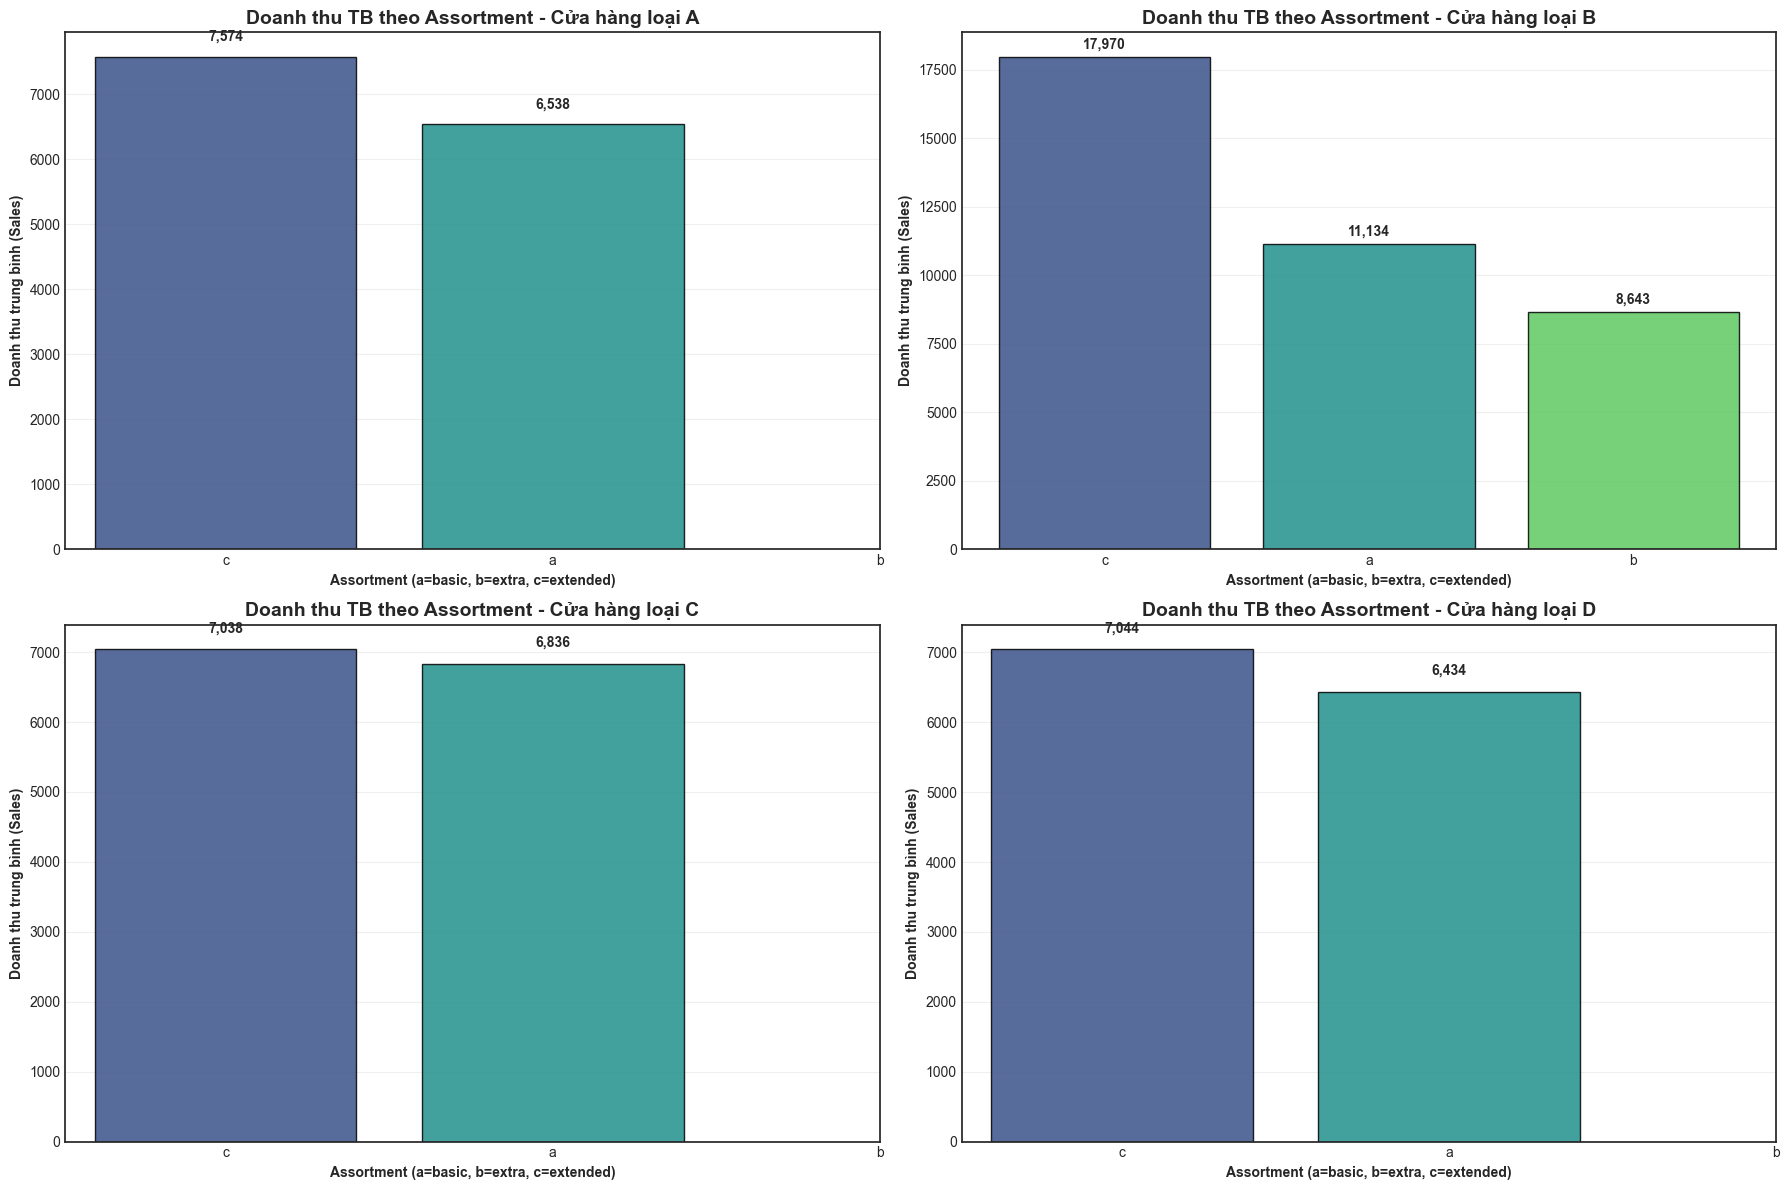

In [324]:
# Vẽ biểu đồ thể hiện mối quan hệ giữa doanh thu và `Assortment` theo thời gian và loại cửa hàng
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

store_types = ['a', 'b', 'c', 'd']

for idx, store_type in enumerate(store_types):
    ax = axes[idx]
    # Lọc dữ liệu theo loại cửa hàng và có doanh thu > 0
    df_store_type = sales_positive[sales_positive['StoreType'] == store_type]
    
    if df_store_type.empty:
        ax.set_visible(False)
        continue
    
    # Tính doanh thu trung bình theo Assortment
    avg_sales_by_assortment = df_store_type.groupby('Assortment', observed=False)['Sales'].mean().sort_values(ascending=False)
    
    # Tạo màu sắc cho từng loại assortment
    colors = sns.color_palette('viridis', len(avg_sales_by_assortment))
    
    # Vẽ barplot
    ax.bar(range(len(avg_sales_by_assortment)), avg_sales_by_assortment.values, 
           color=colors, edgecolor='black', alpha=0.85)
    ax.set_xticks(range(len(avg_sales_by_assortment)))
    ax.set_xticklabels(avg_sales_by_assortment.index, rotation=0)
    
    ax.set_title(f'Doanh thu TB theo Assortment - Cửa hàng loại {store_type.upper()}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Assortment (a=basic, b=extra, c=extended)', fontweight='bold')
    ax.set_ylabel('Doanh thu trung bình (Sales)', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm nhãn giá trị trên các cột
    for i, v in enumerate(avg_sales_by_assortment.values):
        ax.text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

Khó để đi sâu vào phân tích về `assortment` khi dữ liệu rất mất cân bằng, theo quan sát biểu đồ trên thì chỉ có các cửa hàng `StoreType b` mới có `Assortment b` và doanh thu trung bình của `Assortment c` luôn cao hơn  `Assortment a`

#### Correlation Matrix

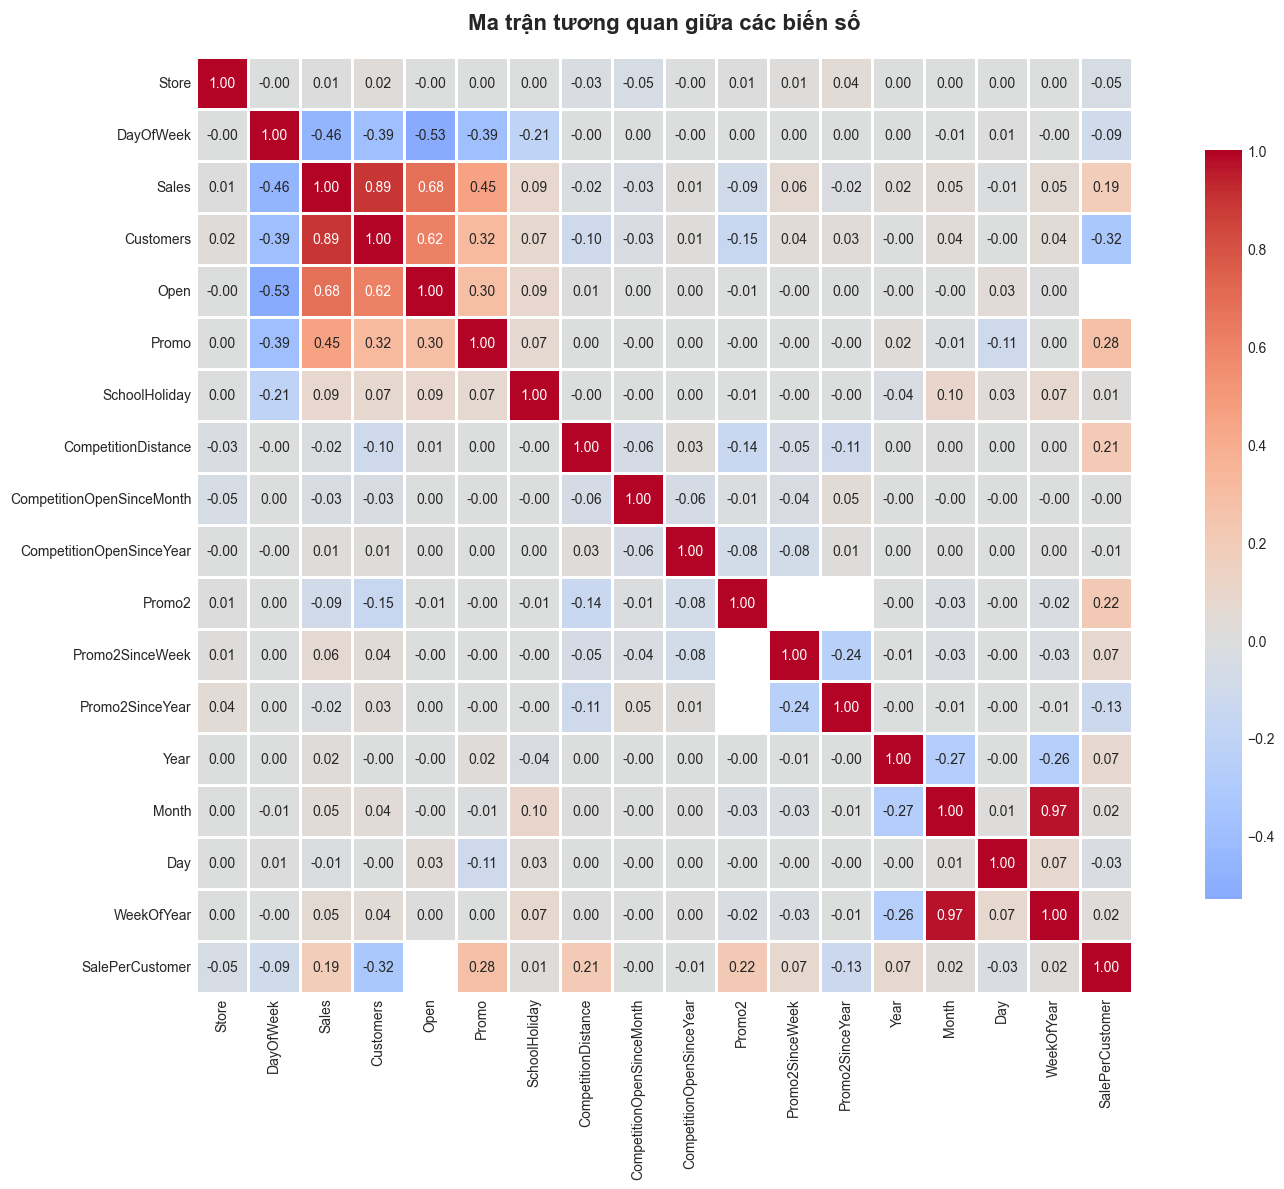

In [325]:

numerical_features = df_merged.select_dtypes(include=[np.number]).columns.tolist()

# Tính ma trận tương quan
correlation_matrix = df_merged[numerical_features].corr()

# Vẽ heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận tương quan giữa các biến số', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Các biến `Dayofweek`, `Sales`, `Customers`, `Open`, `Promo` có tương quan với nhau khá rõ rệt, trong khi các biến còn lại hầu như không có tương quan với nhau.

#### Kết luận phân tích đa biến


<b> 1. Về thời gian, mùa vụ </b>
- Các cửa hàng thường tăng doanh thu rất mạnh vào cuối năm khoảng tháng 11 và 12, đối với các ngày trong tuần các cửa hàng loại a,c,d đều sụt giảm doanh thu trầm trọng vào ngày chủ nhật còn cửa hàng `StoreType b` lại tăng doanh thu vào ngày chủ nhật nhưng lại sụt giảm sâu vào ngày thứ 7

- Cửa hàng `StoreType b` có doanh thu trung bình cao nhất vào ngày lễ phục sinh, trong khi các cửa hàng khác thu được doanh thu trung bình cao nhất vào các ngày lễ thường và không phải ngày lễ

- Cửa hàng `StoreType c` không có doanh thu vào dịp lễ phục sinh

- Các ngày nghỉ lễ ở trường (`SchoolHoliday`) có vẻ như không có quá nhiều tác động đến doanh thu của các loại cửa hàng

<b> 2. Về doanh thu </b>
- Cửa hàng `StoreType b` đúng là có số lượng khách trung bình ngày doanh thu trung bình ngày nhiều nhất nhưng số lượng store lại ít nhất nên tổng doanh thu sẽ ít nhất nhưng performance rất tốt, đây là loại cửa hàng hiếm vì số lượng store ít và khách hàng vào mua đông nhưng mua với giá trị ít

- Cửa hàng `StoreType d` ngược lại có doanh thu và số khách trung bình ngày ít nhất nhưng `SalePerCustomer` lại vượt trội nhất, đây là loại cửa hàng có lẽ là bán hàng hóa có giá trị cao nhất nên mới ít khách và `SalePerCustomer` cao

- Doanh thu trung bình tại cửa hàng `StoreType b` luôn vượt trội so với các loại cửa hàng khác dù là dịp lễ hay không phải dịp lễ

<b> 3. Ảnh hưởng của promotion </b>
- Loại cửa hàng `StoreType b` luôn có doanh thu cao nhất khi áp dụng cả 2 loại promotion `promo` và `promo2` 

- Xu hướng biến động doanh thu ở cả 2 biểu đồ của 2 biến `promo` và `promo2` tương đối giống nhau, tuy nhiên ở biểu đồ `promo` thì việc áp dụng mang lại doanh thu cao hơn rõ rệt so với không áp dụng, trong khi ở biểu đồ 
`promo2` thì doanh thu khi áp dụng `promo2` lại thấp hơn so với không áp dụng. Điều này cho thấy các biến promotion thật sự cần được phân tích sâu hơn để hiểu được nguyên nhân đằng sau.

<b> 4. Về đối thủ </b>
- Thâm niên đối thủ thể hiện ảnh hưởng rõ rệt nhất đến cửa hàng loại b, cần khám phá sâu hơn câu chuyện đằng sau


### <b>Kết luận cuối cùng cho phần EDA</b>


<b>Khám phá dữ liệu cho thấy rất nhiều các insight thú vị, trong đó có thể trích ra được 1 số insight hay nhất và còn nhiều thắc mắc nhất sẽ được khai thác trong phần tiếp theo:</b>
1. Doanh thu trung bình tại cửa hàng `StoreType b` luôn vượt trội so với doanh thu trung bình của các loại cửa hàng còn lại bất kể yếu tố thời gian, hay dịp lễ nhưng lại có doanh thu trung bình mỗi khách hàng là thấp nhất do cửa hàng rất đông khách nhưng mỗi khách hàng chỉ mua với giá trị nhỏ.

2. Doanh thu trung bình mỗi khách hàng của cửa hàng `StoreType d` là cao nhất nhưng doanh thu trung bình ngày và số khách hàng trung bình theo ngày lại thấp nhất cho thấy đây là cửa hàng tập trung vào việc bán các dòng sản phẩm cao cấp với giá cả mặt hàng cao hơn các loại cửa hàng khác.

3. Doanh thu trung bình ghi nhận trong năm 2015 tính đến tháng 7 theo tập dataset này cao hơn so với doanh thu trung bình các năm trước dù chưa trải qua sự bùng nổ doanh thu vào cuối năm, cho thấy rõ nét về hiệu quả trong tăng trưởng kinh doanh của Rossmann store.

4. Yếu tố `promotion` dài hạn và ngắn hạn đều ảnh hưởng rõ rệt đến doanh số của tất cả các loại cửa hàng nhưng cần làm rõ hơn ở mửc độ ảnh hưởng và các vấn đề liên quan sẽ được tìm hiểu trong phần phân tích sâu tiếp theo.

5. Yếu tố về `thời gian mùa vụ` ảnh hưởng đến doanh thu đã được thể hiện rõ, hầu như các cửa hàng đều tăng doanh thu mạnh vào tháng cuối năm, hay vào các ngày nghỉ lễ một số loại cửa hàng tăng còn 1 số loại thì không, đây cũng là 1 vấn đề sẽ được đào sâu hơn trong phần phân tích sâu tiếp theo.

6. Yếu tố `đối thủ cạnh tranh` cũng đưa ra được 1 insight thú vị , thâm niên của cửa hàng đối thủ ảnh hưởng lớn đến loại cửa hàng, nhất là cửa hàng loại b. Đây là một yếu tố cần đào sâu làm rõ hơn để trả lời cho các câu hỏi tại sao và sự thật đằng sau các insight kể trên cũng như khám phá ra được các câu chuyện mới liên quan đến đối thủ cạnh tranh, yếu tố về đối thủ cạnh tranh cũng sẽ được phân tích sâu hơn trong phần tiếp theo.
